In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import ppscore as pps
import statsmodels.api as sm

warnings.simplefilter("ignore")
%matplotlib inline

In [127]:
train = pd.read_csv("../data/train.csv", index_col = [0])
test = pd.read_csv("../data/test.csv", index_col = [0])

In [90]:
def assess_pps(data):
    result = {}
    for x in data.columns:
        result[x] = []
        for y in data.columns:
            try:
                score = pps.score(data, x, y)["ppscore"]
                if score >= 0.5:
                    result[x].append(score)
                else:
                    if ((x == "SalePrice") or (y == "SalePrice")):
                        result[x].append(score)
                    else:
                        result[x].append(np.NaN)
            except:
                result[x].append(np.NaN)
    result = pd.DataFrame(result, index = data.columns)
    return result

## Preliminary EDA

In [128]:
## categorical to levels conversion
train["ExterQual"] = train["ExterQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["ExterCond"] = train["ExterCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtQual"] = train["BsmtQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtCond"] = train["BsmtCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtExposure"] = train["BsmtExposure"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["HeatingQC"] = train["HeatingQC"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["KitchenQual"] = train["KitchenQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["GarageQual"] = train["GarageQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["GarageCond"] = train["GarageCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

In [125]:
temporal = [var for var in train.columns if ("Yr" in var) 
            or ("Mo" in var) or ("Year" in var)]

levels = ["OverallCond", "OverallQual", "MSSubClass", "BsmtFullBath", 
          "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", 
          "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
        "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC",
         "KitchenQual", "GarageQual", "GarageCond"]

categorical = [var for var in train.columns if (train[var].dtype =='O') 
               and (var not in temporal)
              and (var not in levels)]

numerical = [var for var in train.columns if (train[var].dtype !='O') 
             and (var not in temporal) 
             and (var not in levels)]
numerical_level = levels + numerical

Skewness: 1.882876
Kurtosis: 6.536282


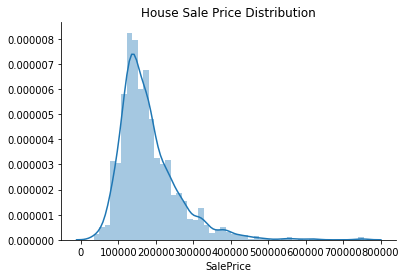

In [104]:
sns.distplot(train["SalePrice"])
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

sns.despine()
plt.title("House Sale Price Distribution")
plt.show()

From the graph above and the statistics measure of skewnewss, we can see that the sale price are skewed to the right, which means that there are some extreme values in the housing sale prices, therefore, to make the data more normalized, a logarithmic tranformation will be used. 

## Assessment based on Temporal Variables

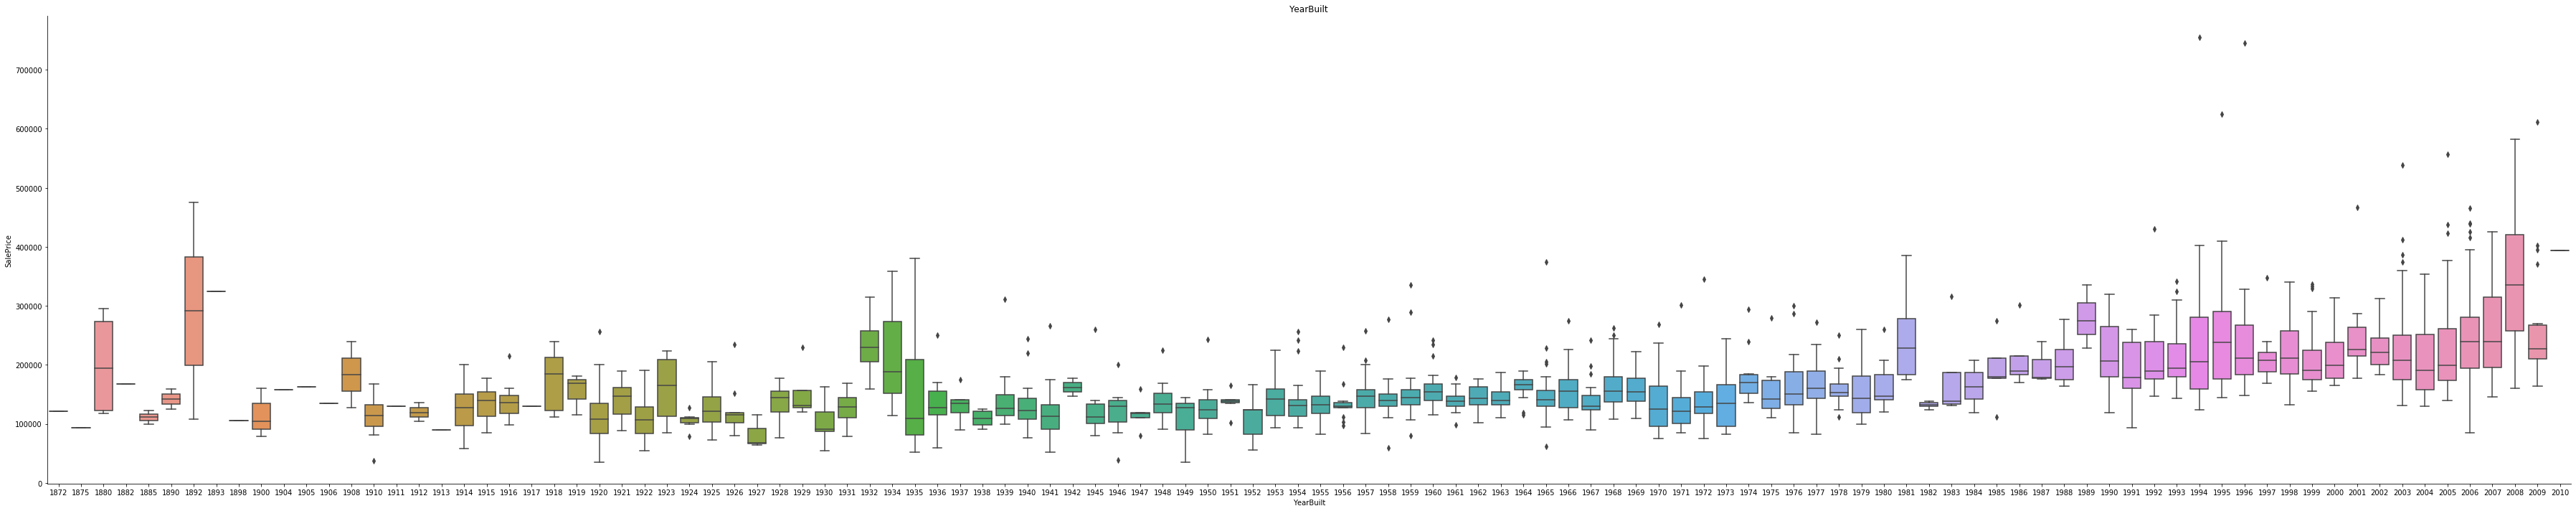

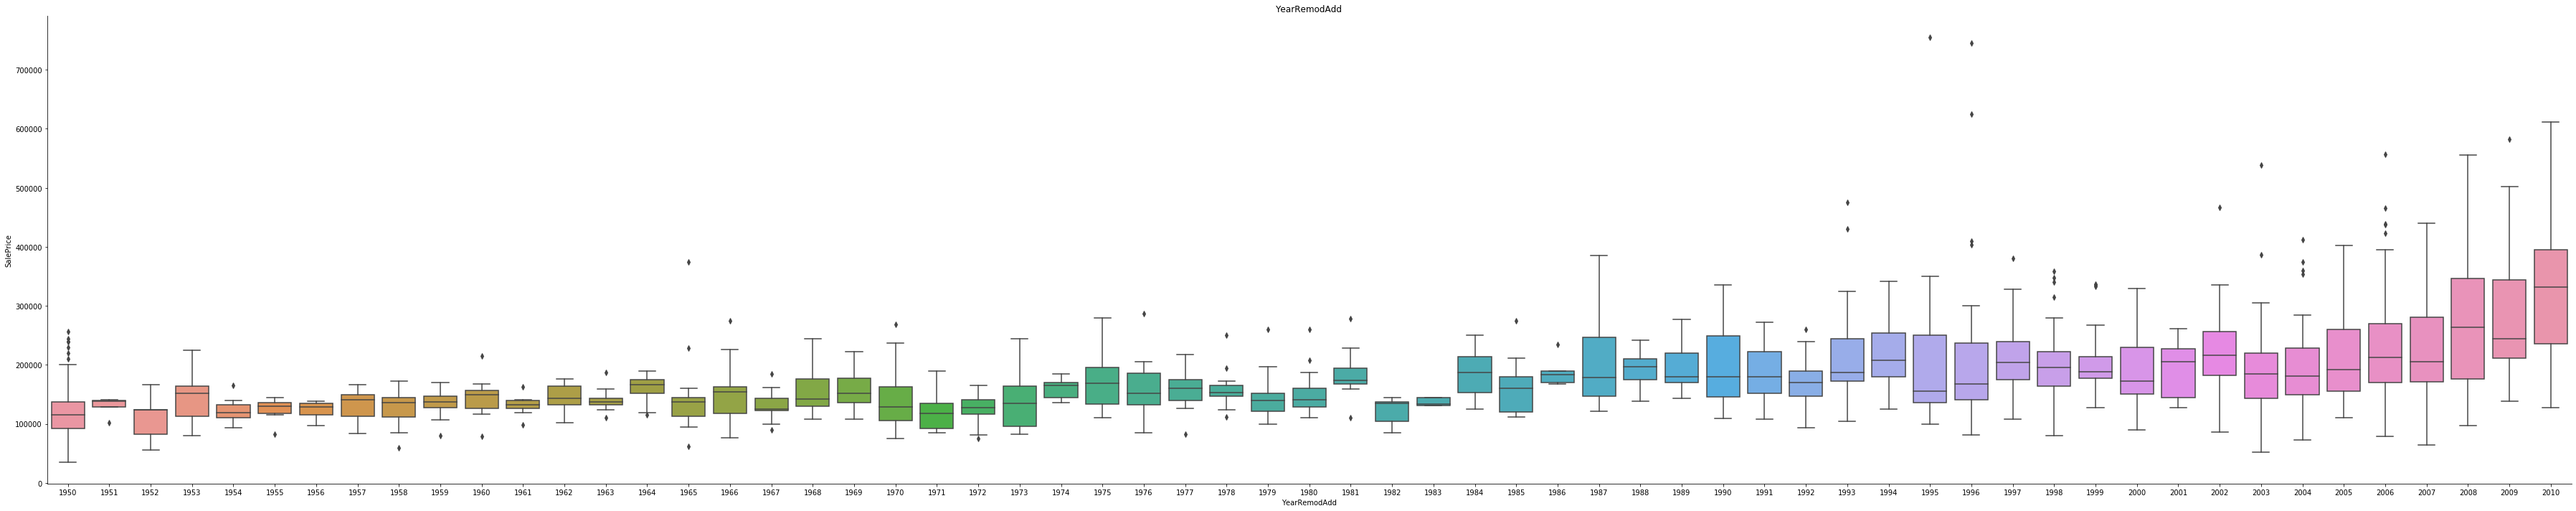

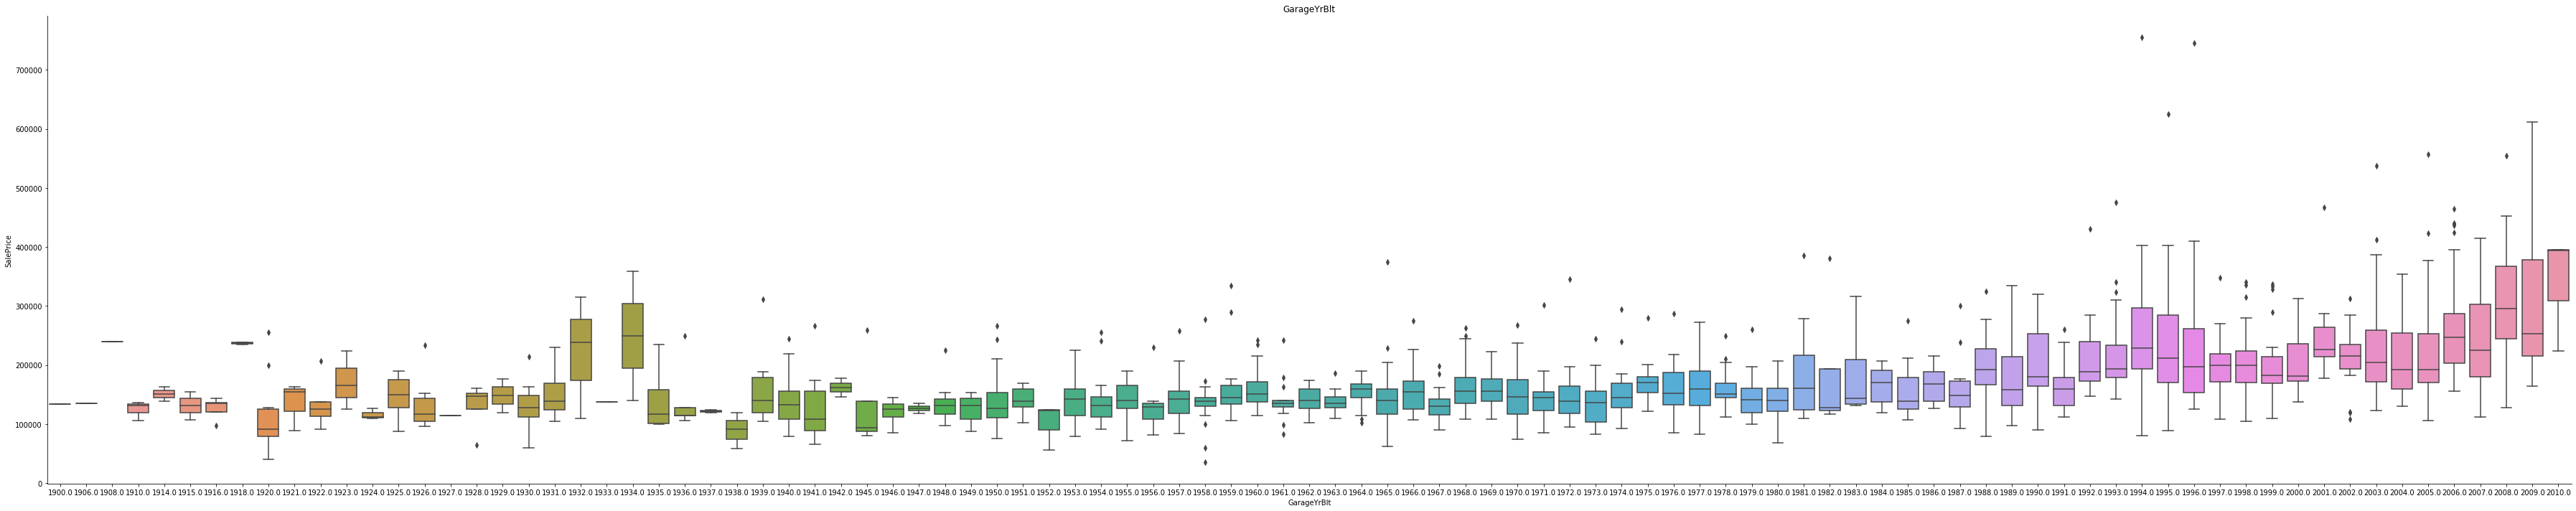

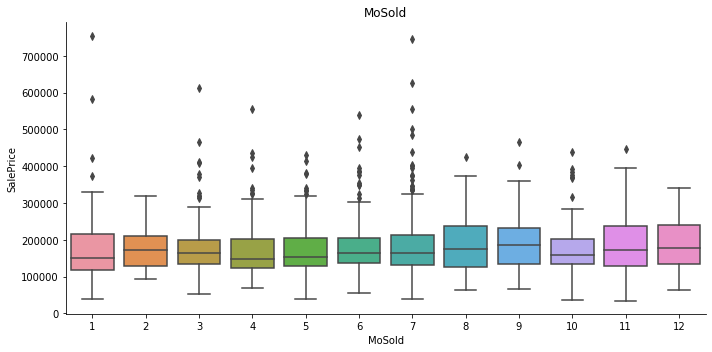

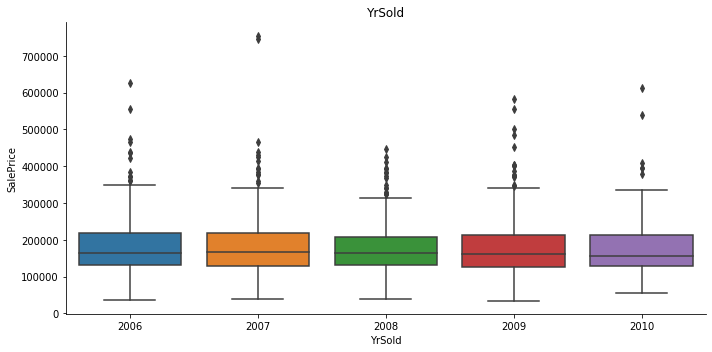

In [105]:
temporal_train = train[temporal]

for i in temporal_train.columns:
    if i == "SalePrice":
        continue
    if len(temporal_train[i].unique()) > 20:
        plt.figure(figsize = (50,10))
    else:
        plt.figure(figsize = (10,5))
    sns.boxplot(x = temporal_train[i], y = train["SalePrice"])
    sns.despine()
    plt.title(i)
    plt.tight_layout()
    plt.show()

As assessed from temporal variables, we do not see any seasonality towards when the house is being sold or which month it is, therefore we do not need to normalize based on inflation of house pricing. If this is the case, it is viable to reduce the temporal variables into smaller subset of variables, such as the age of the house, year since it last got remodelled, and the garage age itself. 

In [106]:
temporal_train["n_temp_houseAge"] = temporal_train["YrSold"] - temporal_train["YearBuilt"]
temporal_train["n_temp_lastRemodelled"] = temporal_train["YrSold"] - temporal_train["YearRemodAdd"]
temporal_train["n_temp_garageAge"] = temporal_train["YrSold"] - temporal_train["GarageYrBlt"]

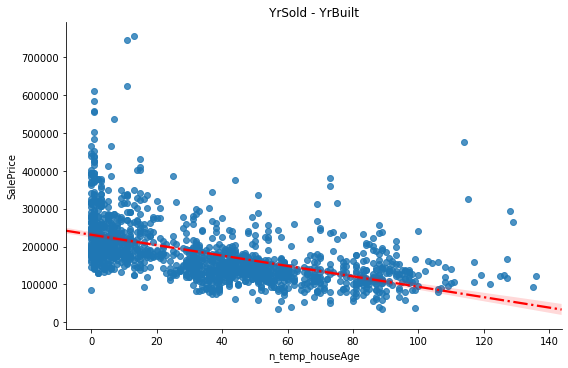

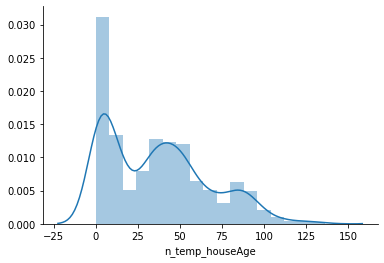

In [107]:
data = pd.concat([temporal_train, train[["SalePrice"]]], axis = 1)
sns.lmplot(x = "n_temp_houseAge", 
           y = "SalePrice", 
           data = data,
          height=5, aspect=1.6, line_kws={'color': 'red', 'linestyle':'-.'})
plt.title("YrSold - YrBuilt")
plt.show()
sns.distplot(data["n_temp_houseAge"])
sns.despine()
plt.show()

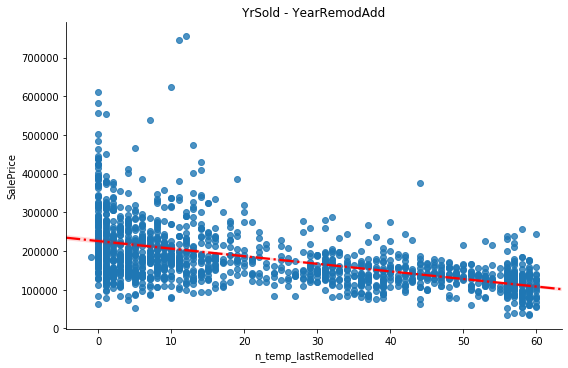

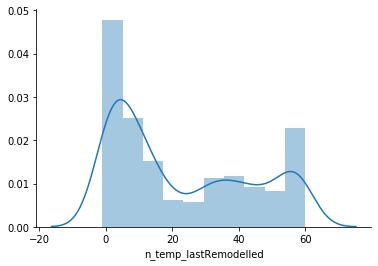

In [108]:
sns.lmplot(x = "n_temp_lastRemodelled", 
           y = "SalePrice", 
           data = data,
          height=5, aspect=1.6, line_kws={'color': 'red', 'linestyle':'-.'})
plt.title("YrSold - YearRemodAdd")
plt.show()
sns.distplot(data["n_temp_lastRemodelled"])
sns.despine()
plt.show()

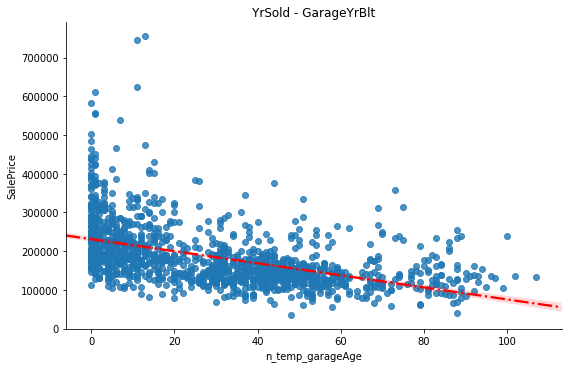

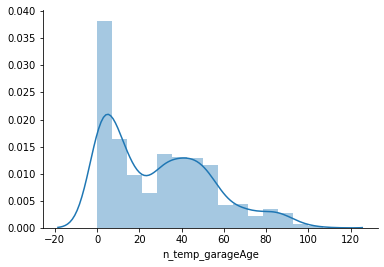

In [109]:
sns.lmplot(x = "n_temp_garageAge", 
           y = "SalePrice", 
           data = data,
          height=5, aspect=1.6, line_kws={'color': 'red', 'linestyle':'-.'})
plt.title("YrSold - GarageYrBlt")
plt.show()
sns.distplot(data["n_temp_garageAge"].dropna())
sns.despine()
plt.show()

In [110]:
data = pd.concat([temporal_train, train[["SalePrice"]]], axis = 1).dropna()
X2 = sm.add_constant((data.drop(["SalePrice"], axis = 1)))
est = sm.OLS(data["SalePrice"], X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     130.3
Date:                Sun, 24 May 2020   Prob (F-statistic):          4.14e-113
Time:                        14:35:48   Log-Likelihood:                -17240.
No. Observations:                1379   AIC:                         3.449e+04
Df Residuals:                    1373   BIC:                         3.452e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.488e+

- Basic hypothesis do yield some consistency that the newer the house is, price should increase.
- By creating feature interaction, we are able to have more statistical significance, especially in how comparing when the house is sold to the last time it is remodelled

## Assessment based on Sale Condition

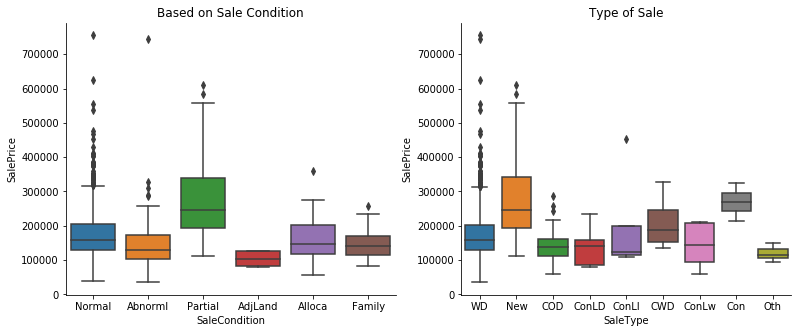

In [111]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (13,5))

sns.boxplot(train['SaleCondition'].fillna("Missing"), train["SalePrice"], ax = axes[0])
sns.despine()
axes[0].set_title("Based on Sale Condition")


sns.boxplot(train['SaleType'].fillna("Missing"), train["SalePrice"], ax = axes[1])
sns.despine()
axes[1].set_title("Type of Sale")
fig.show()

## Assessment of Sale Price Based on Internal Factors

### a. Continuous Variable

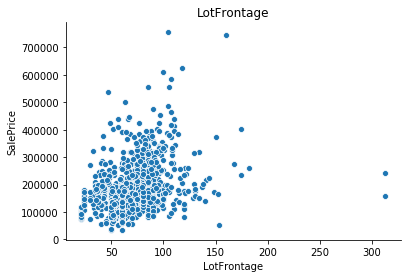

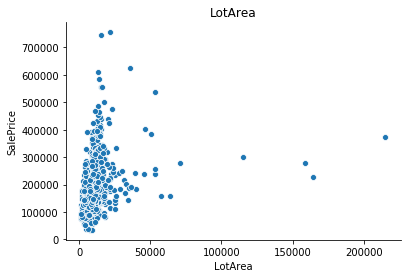

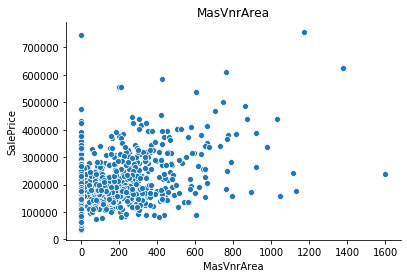

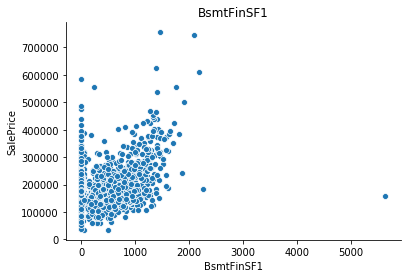

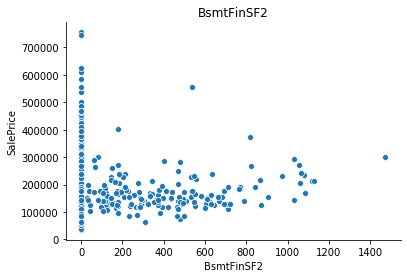

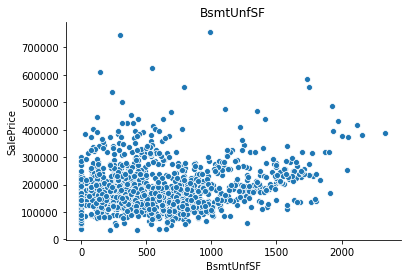

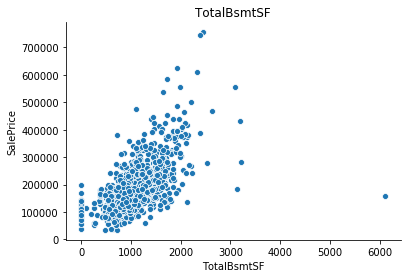

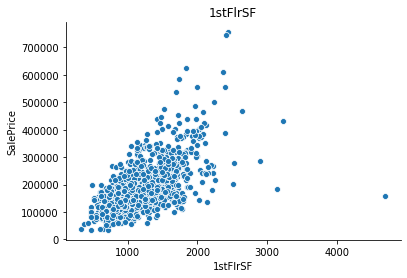

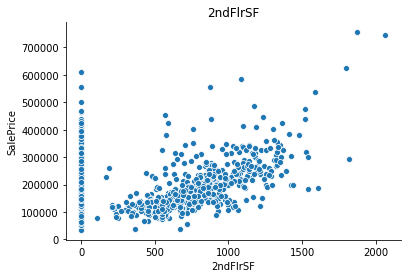

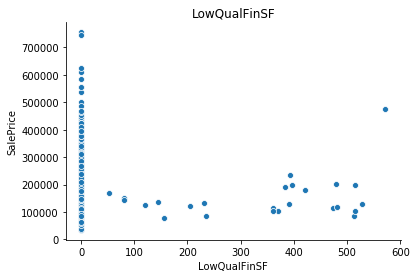

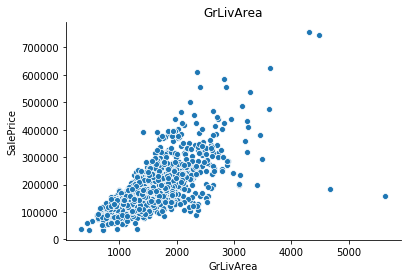

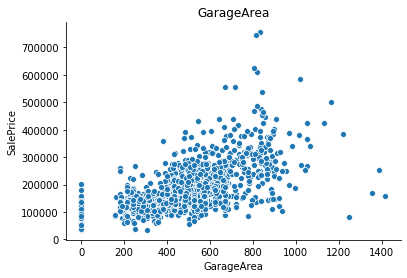

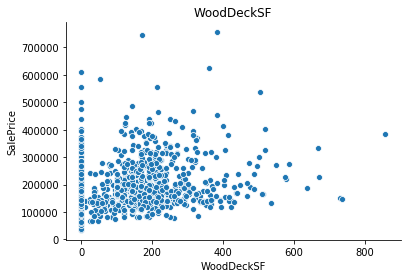

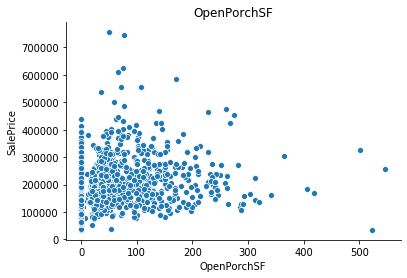

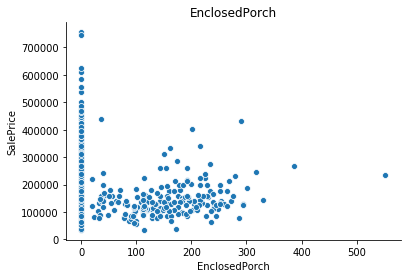

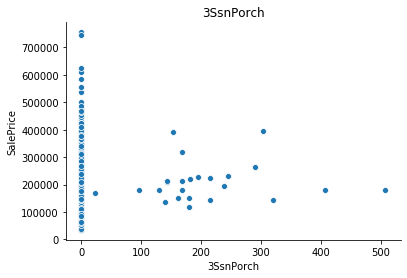

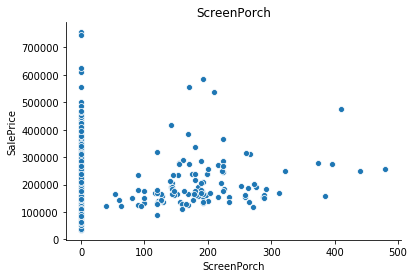

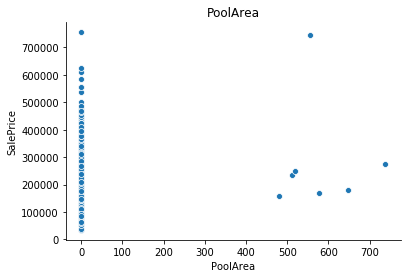

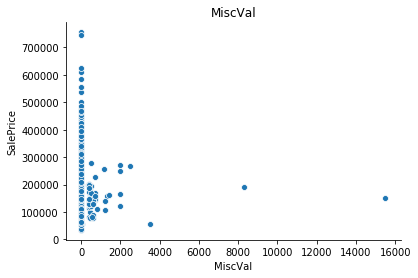

In [112]:
numerical_train = train[numerical]

for i in numerical_train.columns:
    if i == "SalePrice":
        continue
    sns.scatterplot(x = numerical_train[i], y = train["SalePrice"])
    sns.despine()
    plt.title(i)
    plt.show()

## Levels Features (Ranking)

OverallCond


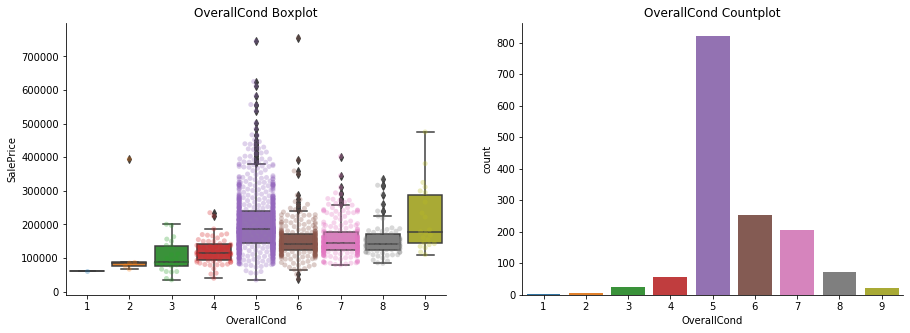

OverallQual


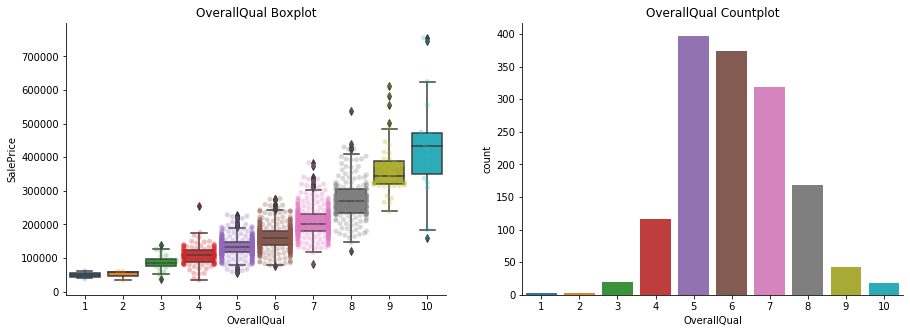

MSSubClass


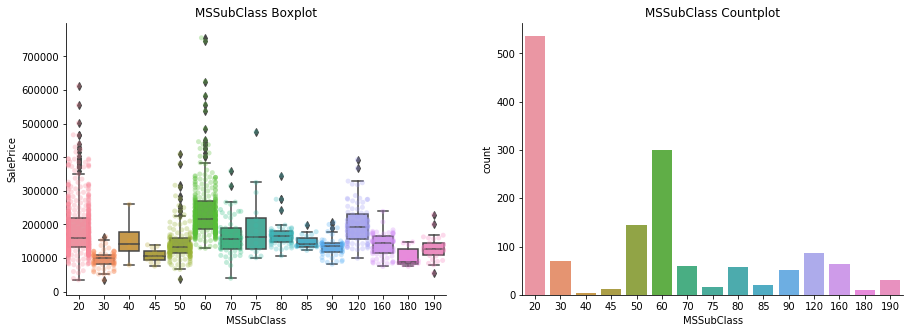

BsmtFullBath


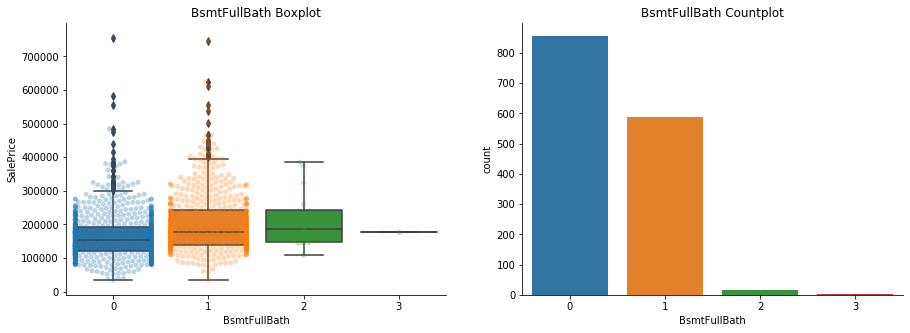

BsmtHalfBath


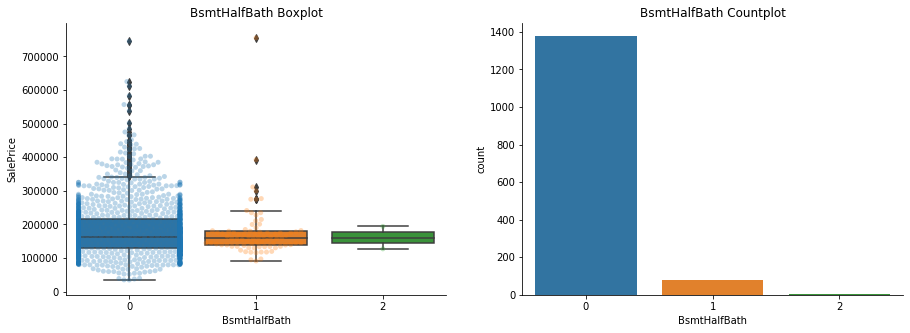

FullBath


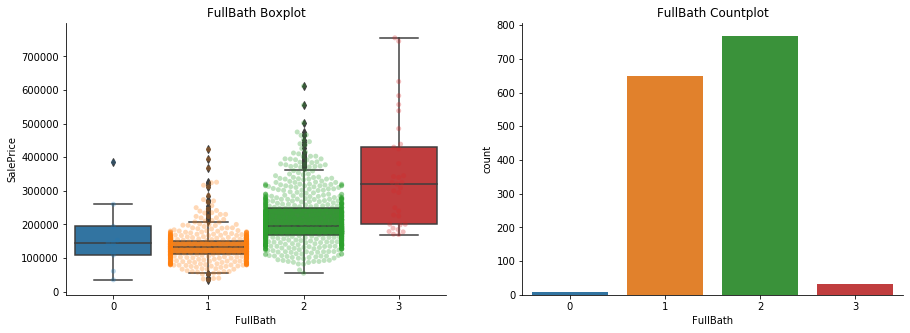

HalfBath


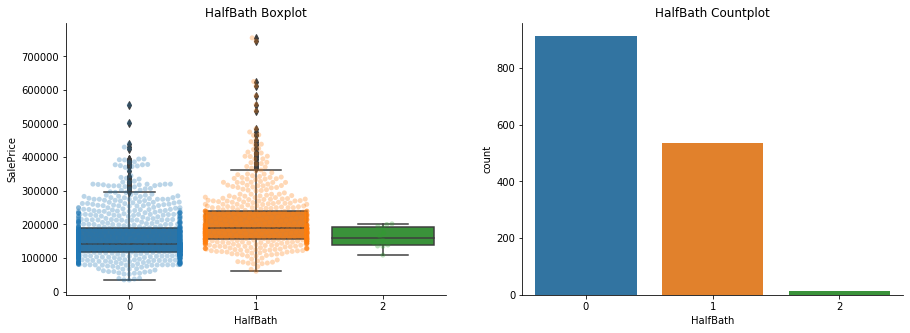

BedroomAbvGr


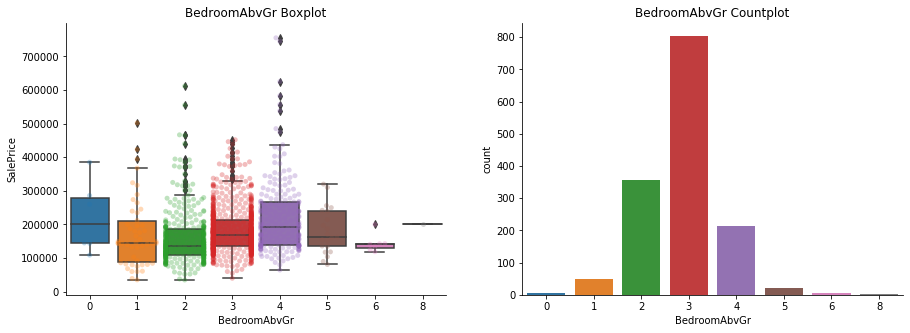

KitchenAbvGr


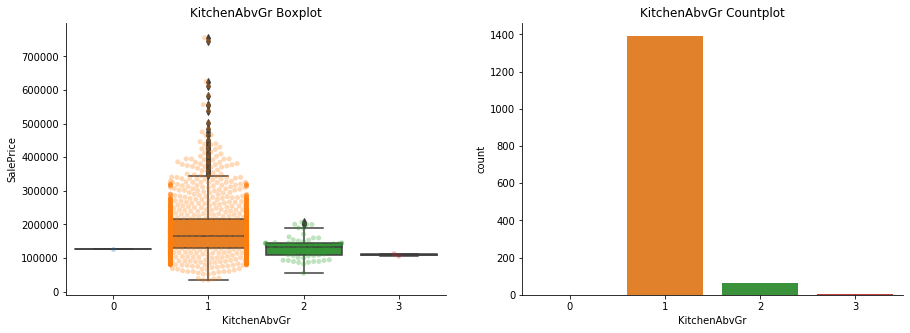

TotRmsAbvGrd


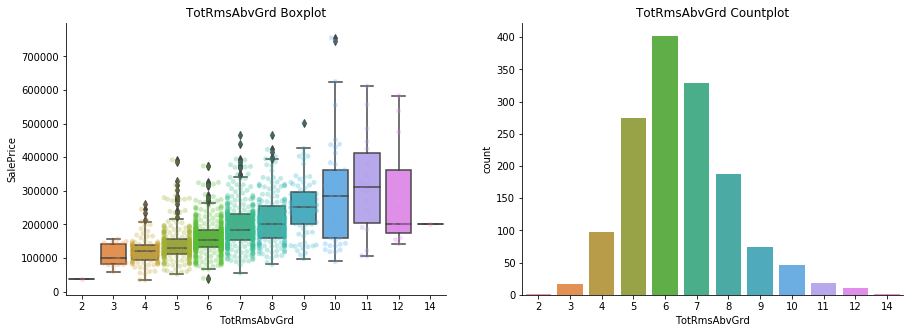

Fireplaces


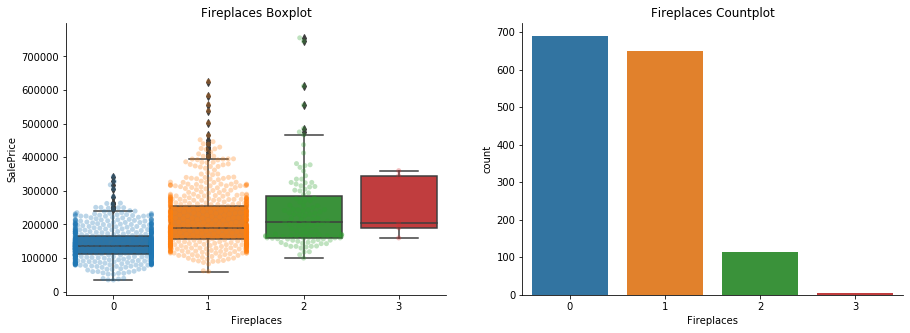

GarageCars


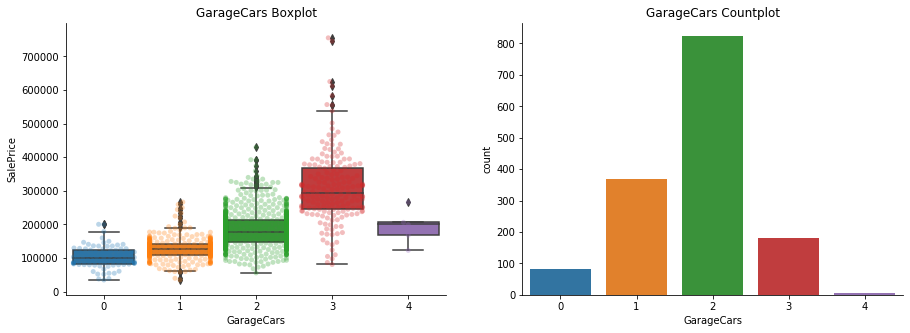

ExterQual


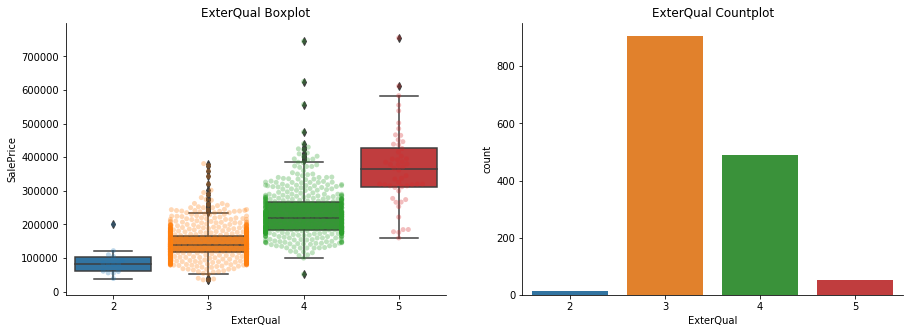

ExterCond


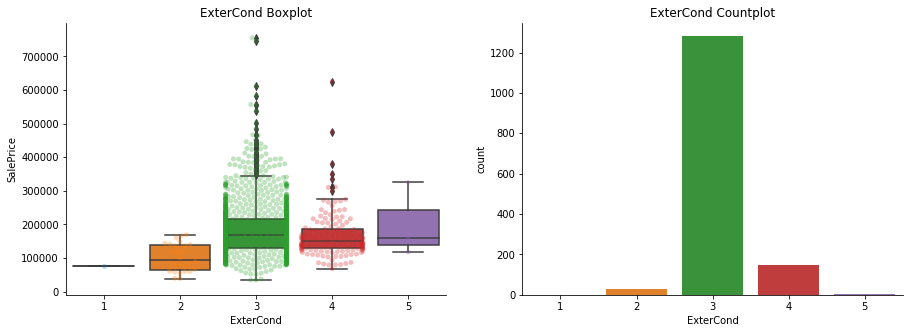

BsmtQual


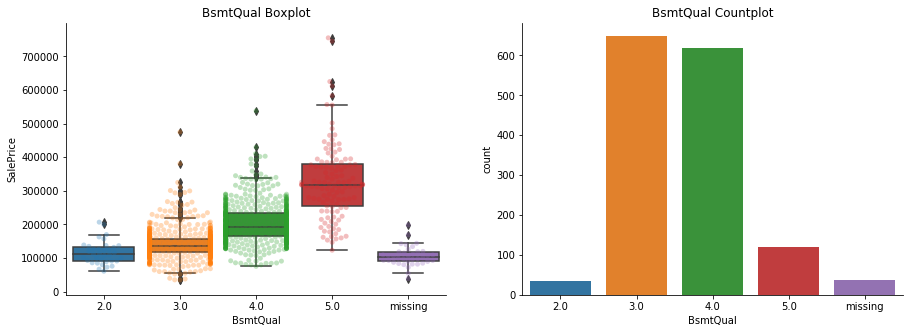

BsmtCond


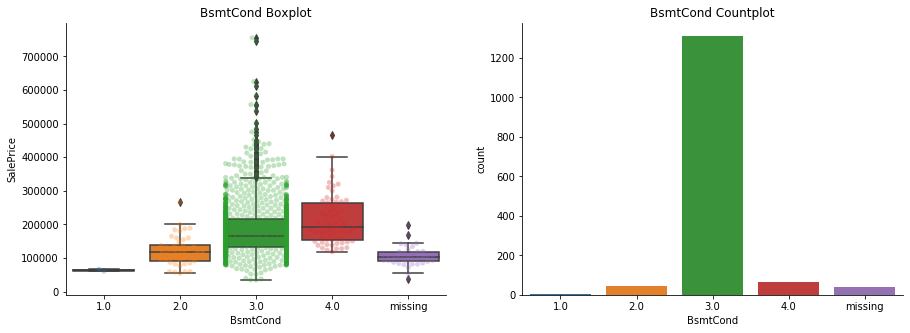

BsmtExposure


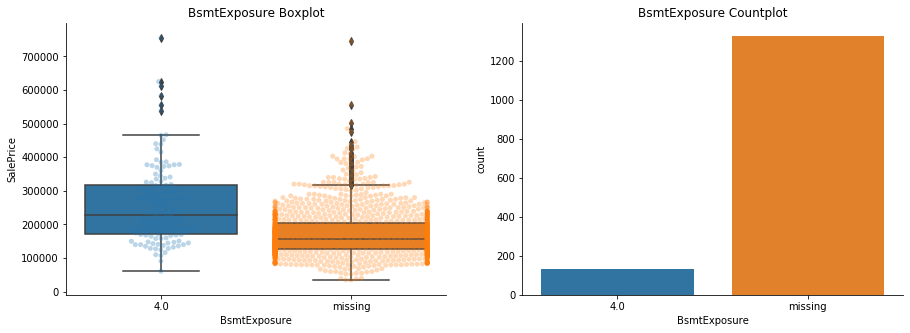

HeatingQC


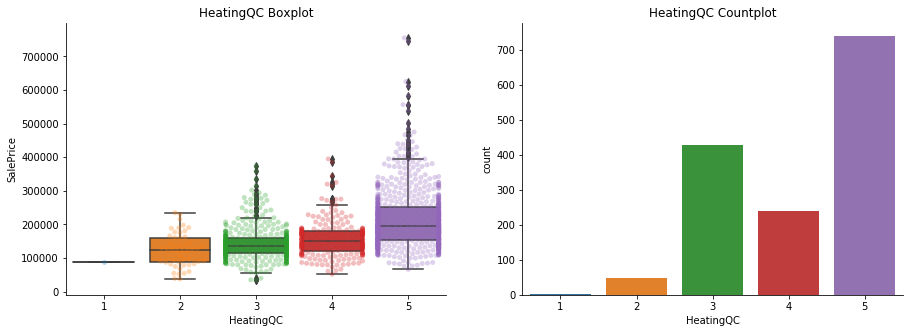

KitchenQual


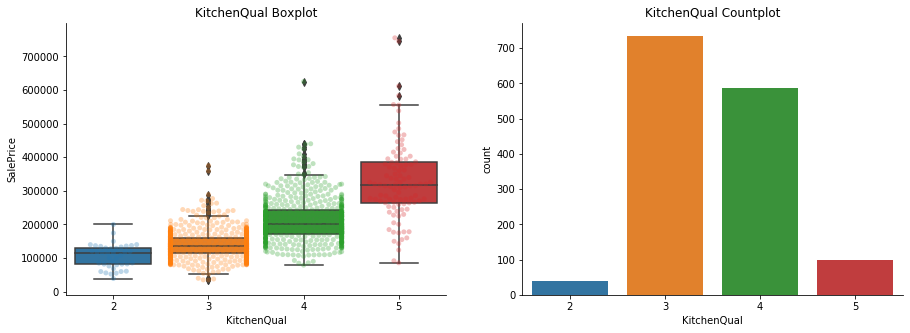

GarageQual


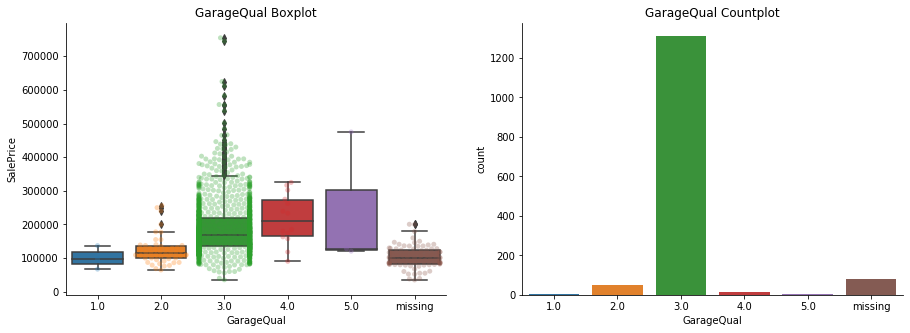

GarageCond


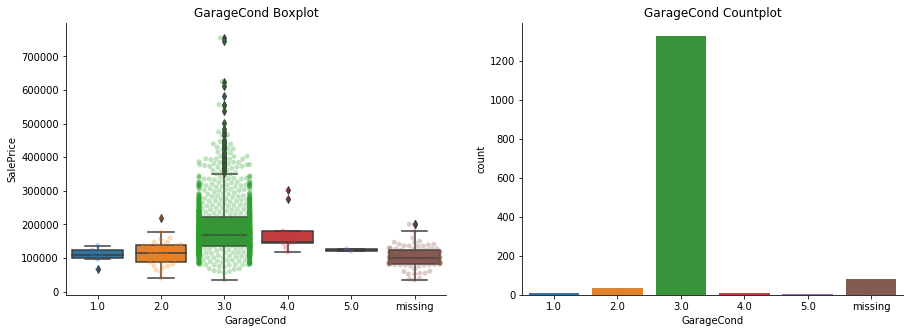

In [150]:
levels_train = train[levels]
data = pd.concat([levels_train, train[["SalePrice"]]], axis = 1)

for i in levels_train.columns:
    print(i)
    if i == "SalePrice":
        continue  
    fig, axes = plt.subplots(nrows =1, ncols = 2, figsize = (15,5))
    sns.boxplot(x = i, 
                y = "SalePrice", 
                data = data[[i, "SalePrice"]].sort_values(by = i, ascending = True).fillna('missing'),
                ax = axes[0])
    sns.swarmplot(x = i, 
                  y = "SalePrice", 
                  data = data[[i, "SalePrice"]].sort_values(by = i, ascending = True).fillna('missing'),
                  ax = axes[0], 
                  alpha=0.3)
    sns.countplot(x = data[i].sort_values(ascending = True).fillna('missing'), 
                  ax = axes[1])
    sns.despine()
    axes[0].set_title("{} Boxplot".format(i))
    axes[1].set_title("{} Countplot".format(i))
    plt.show()

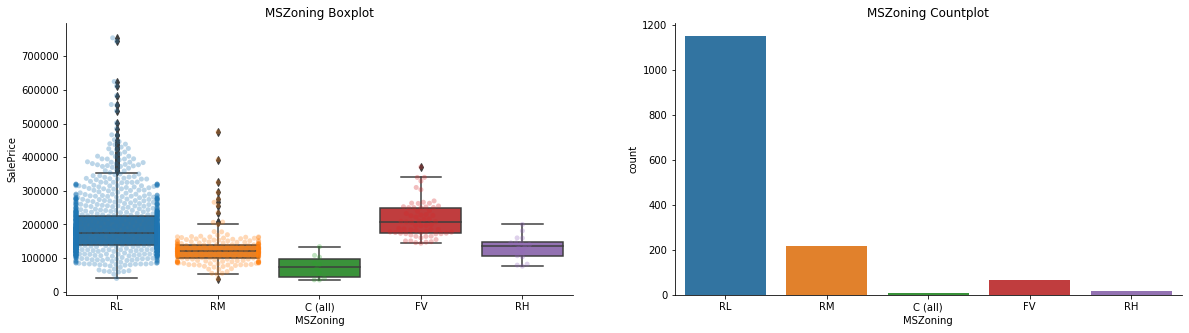

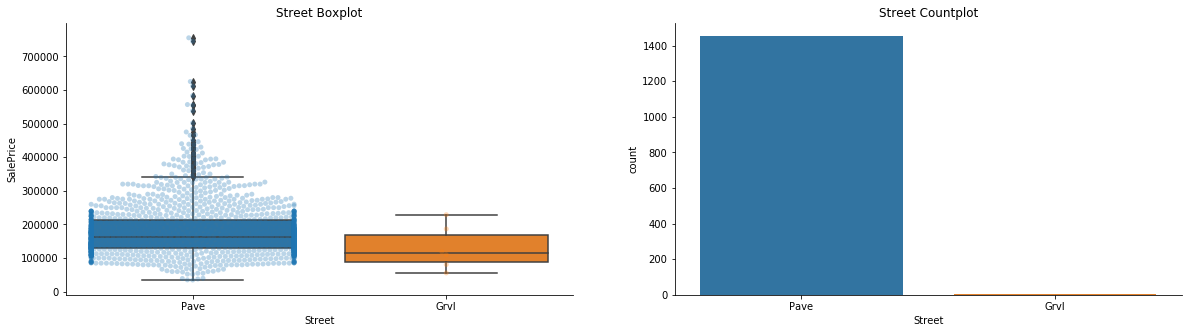

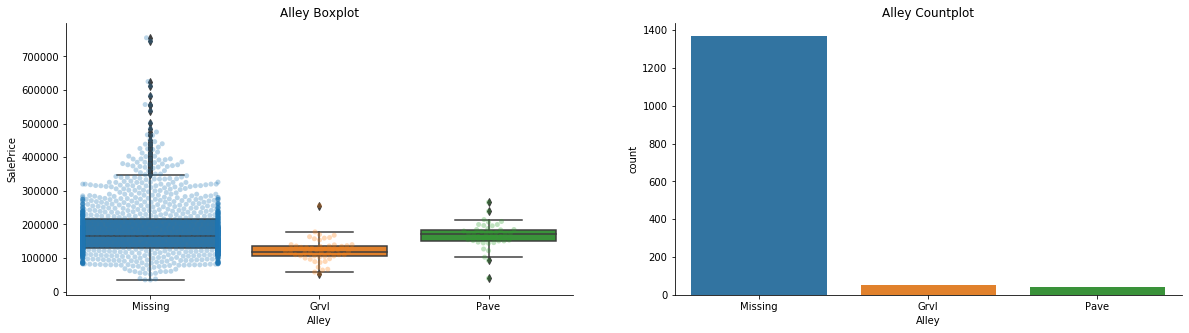

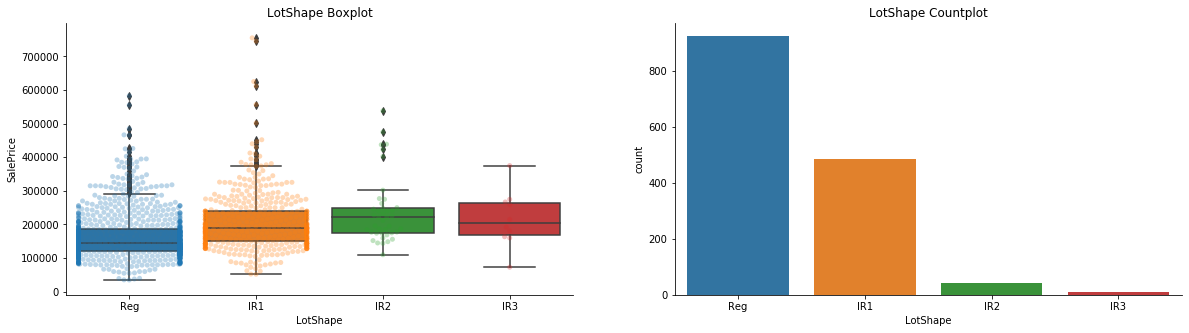

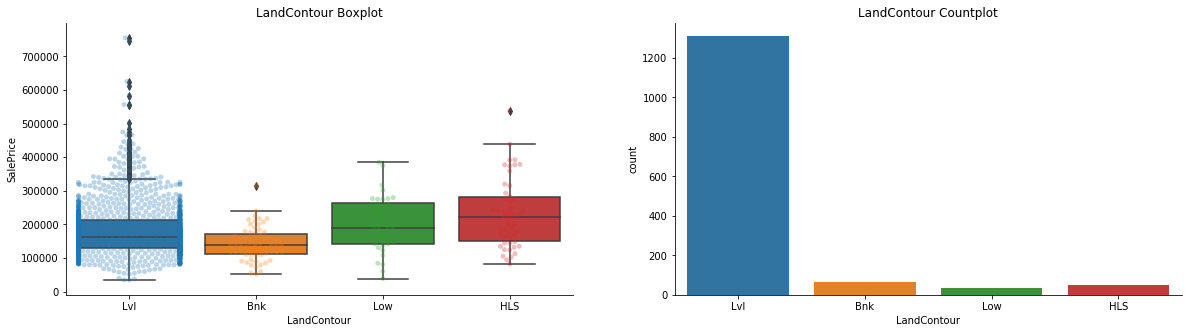

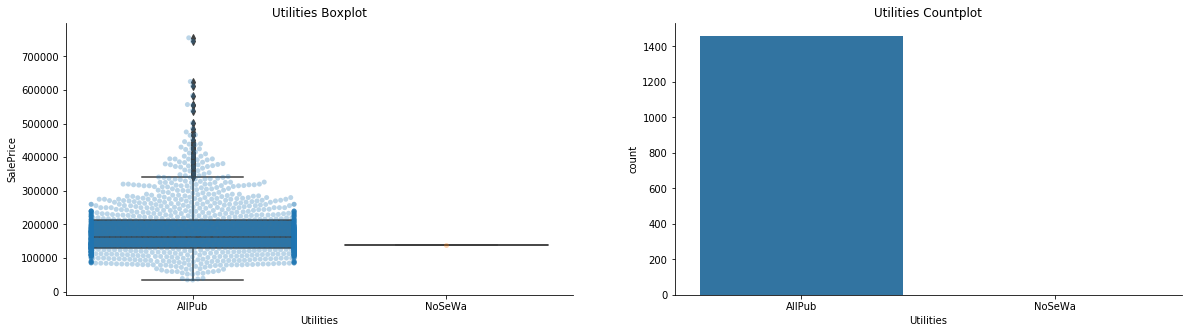

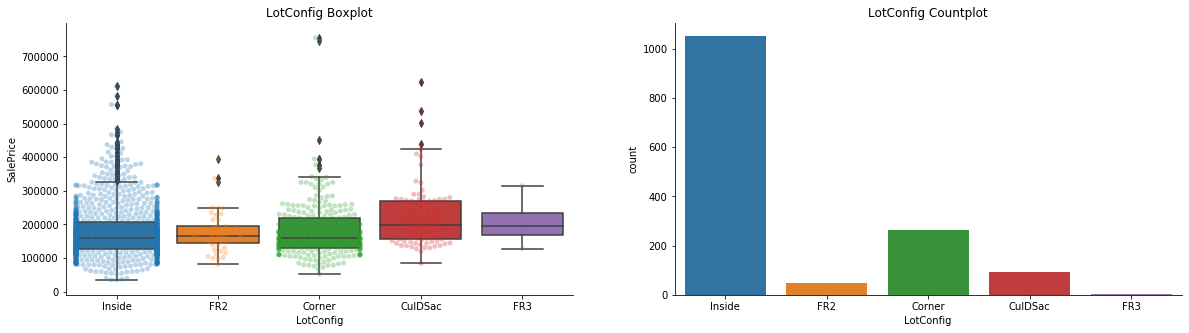

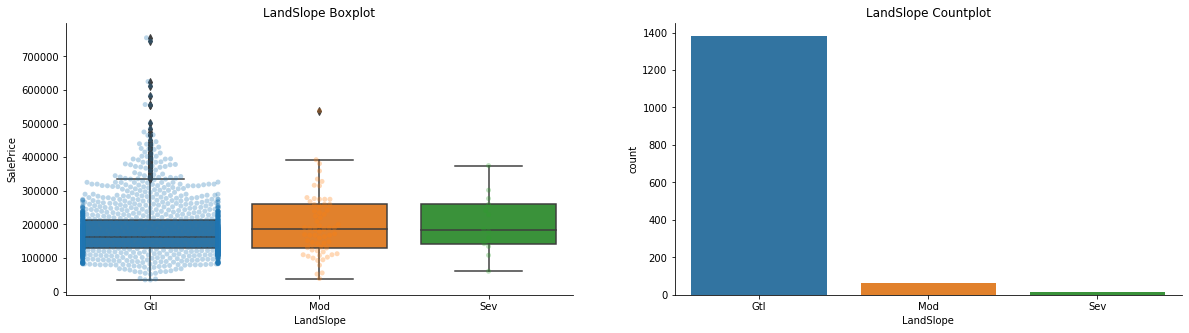

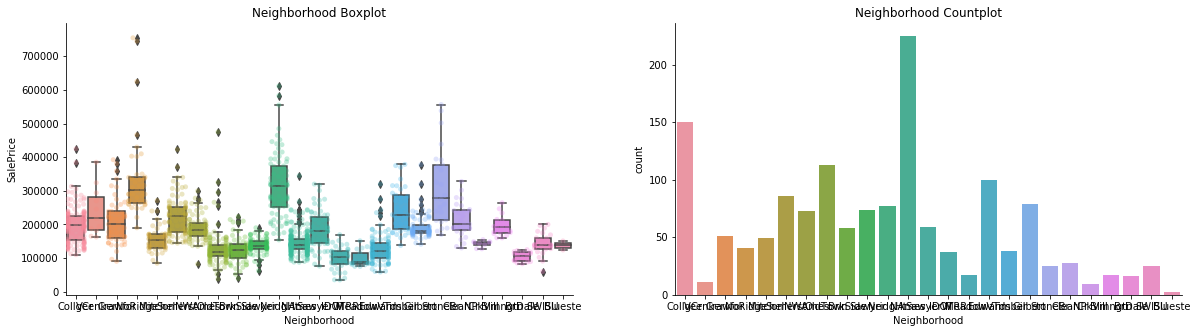

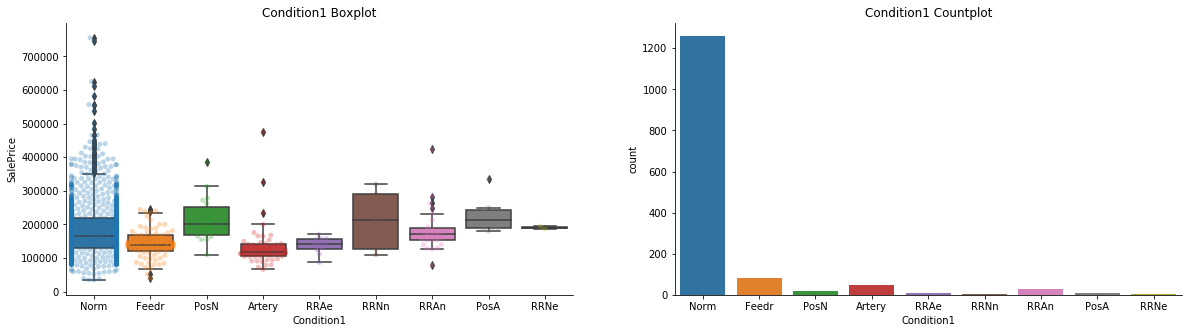

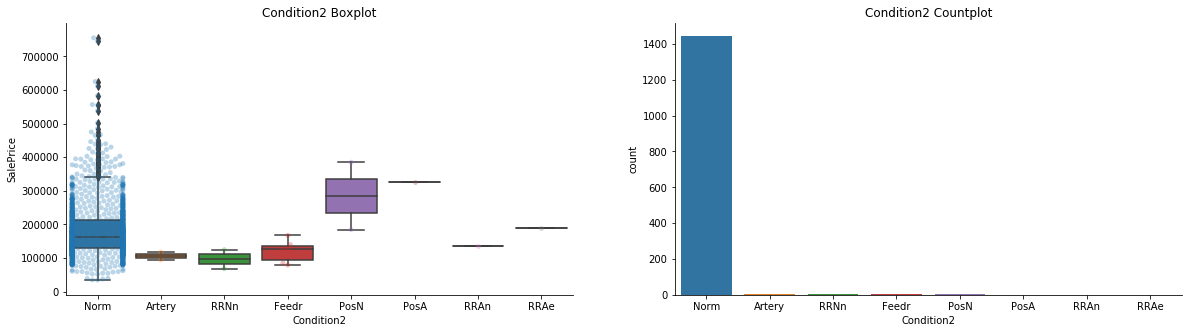

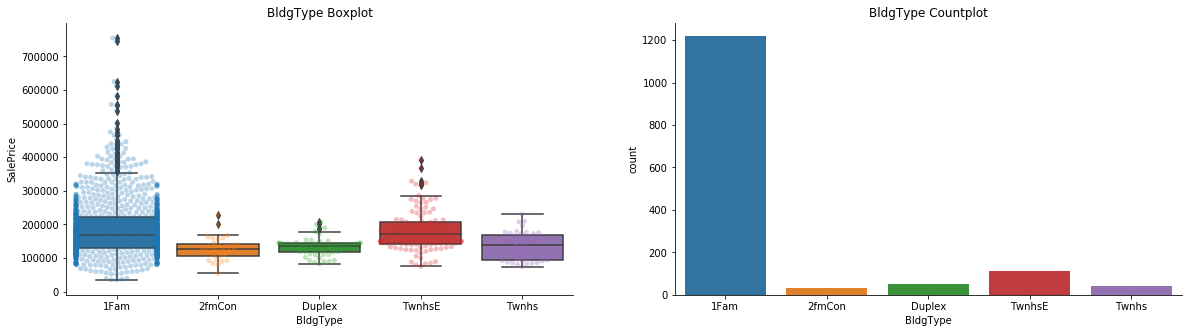

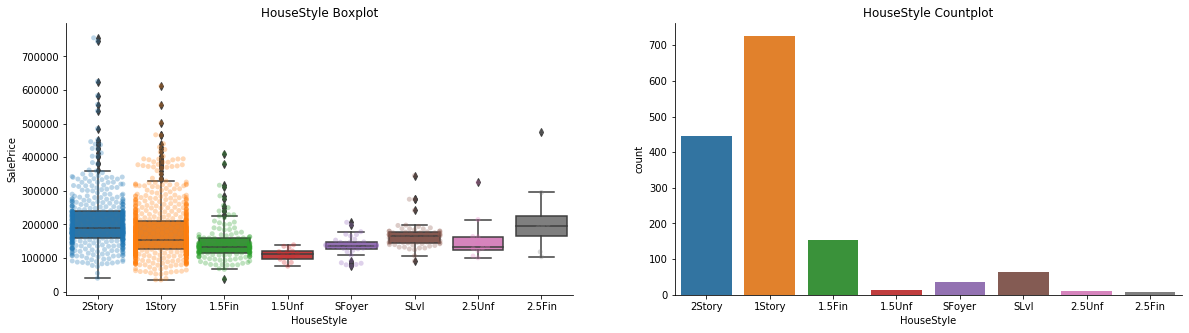

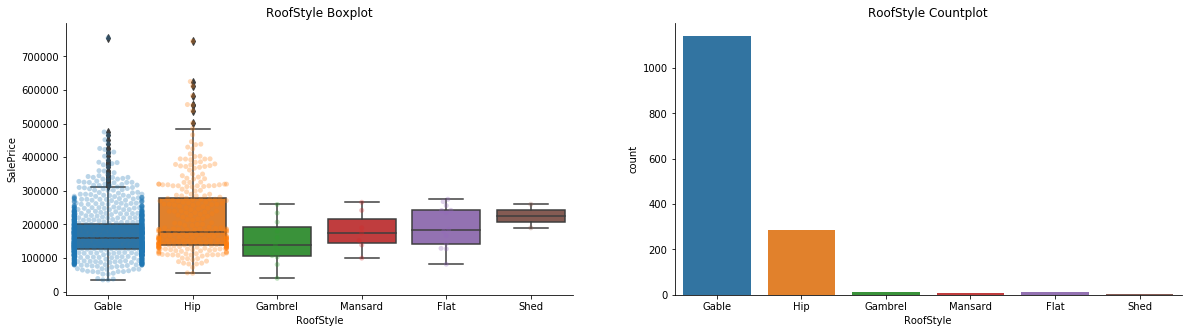

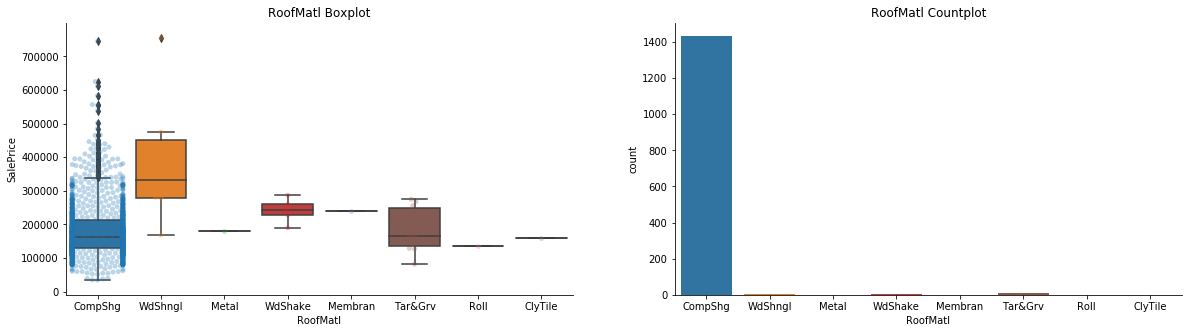

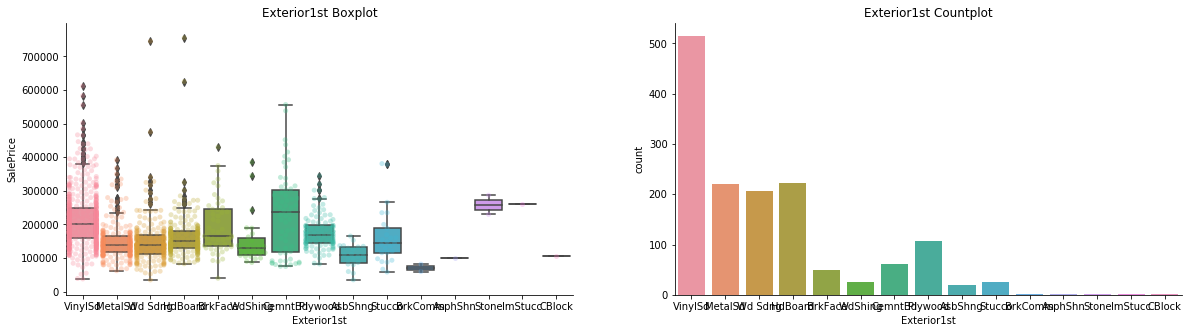

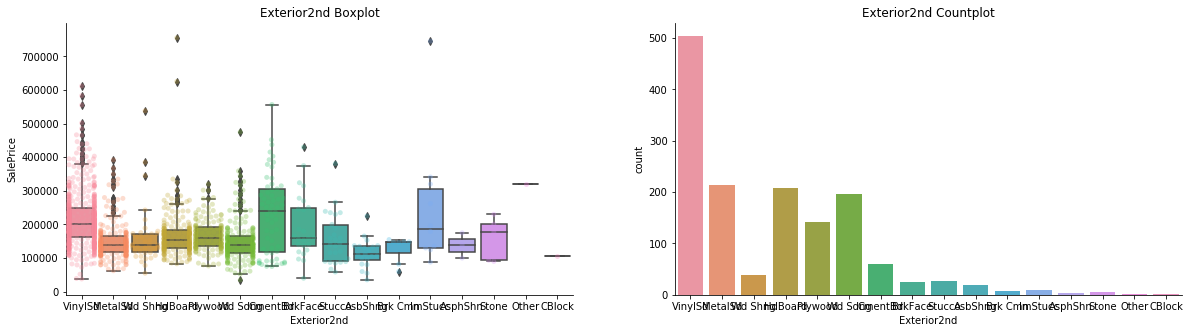

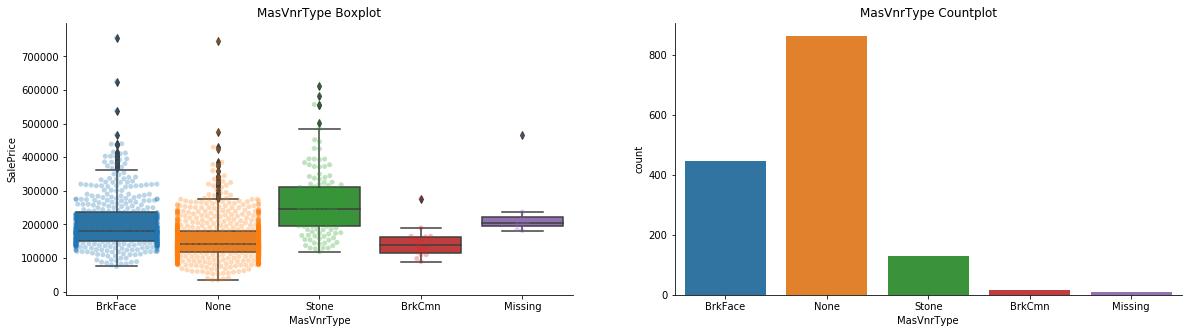

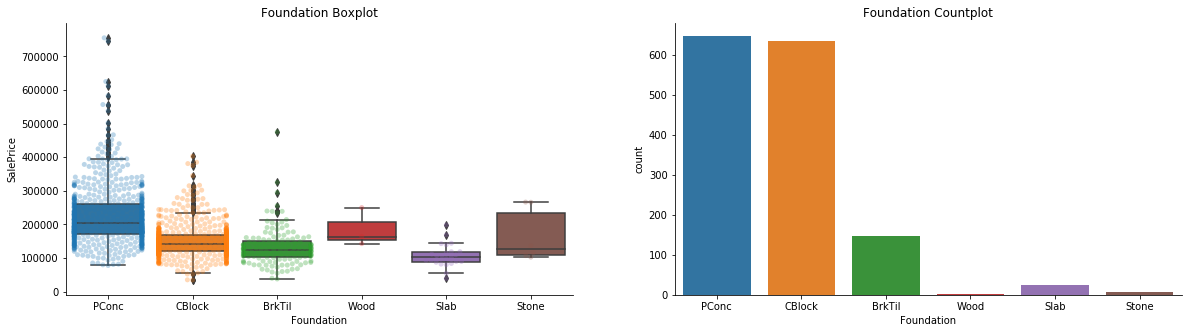

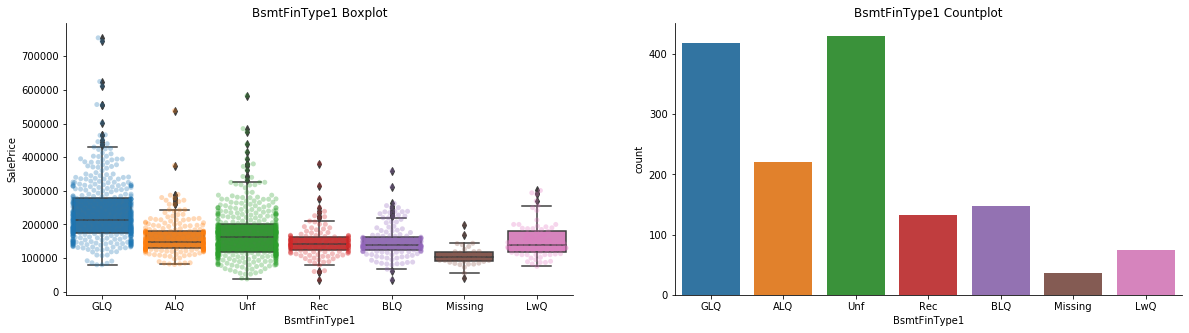

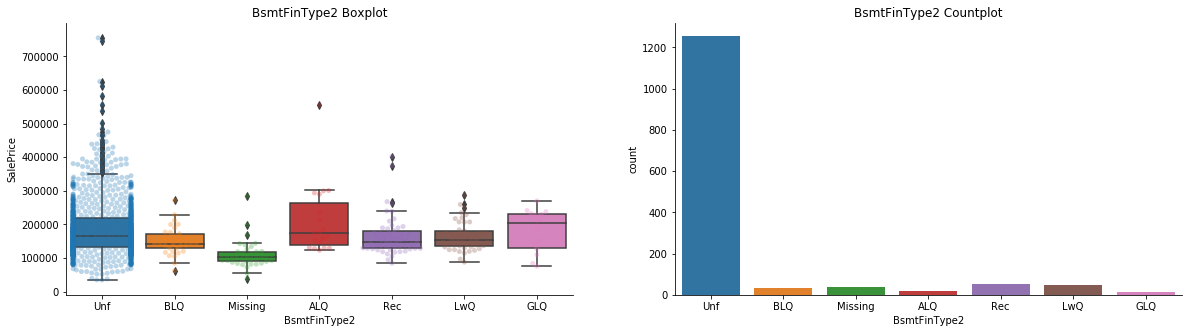

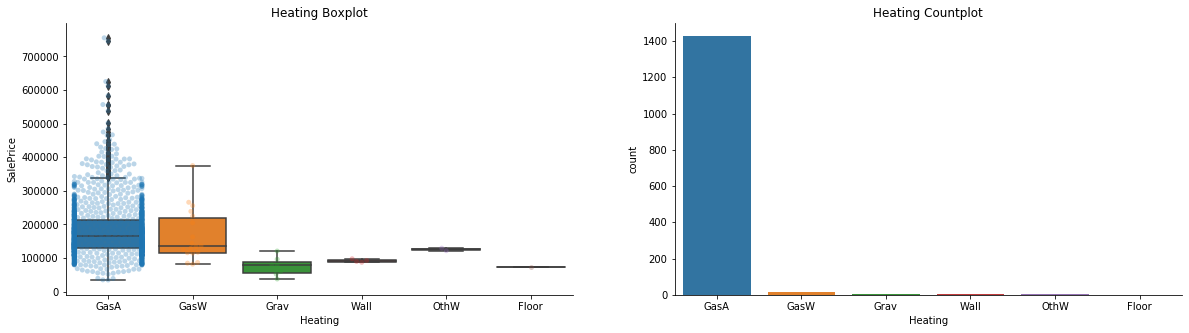

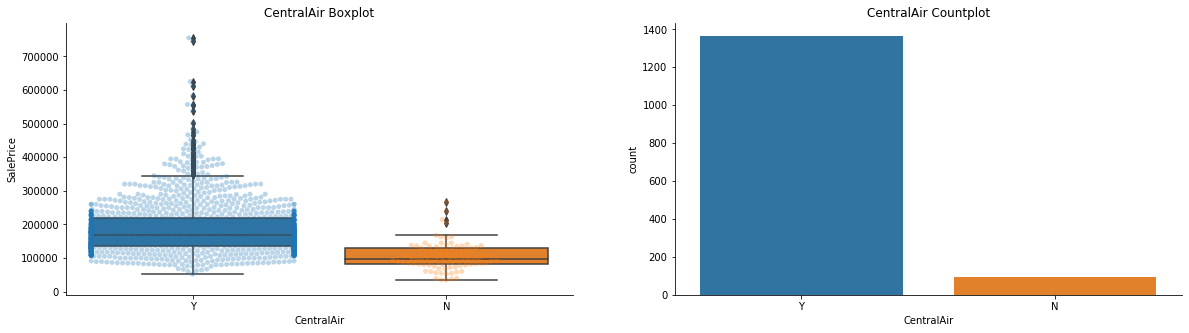

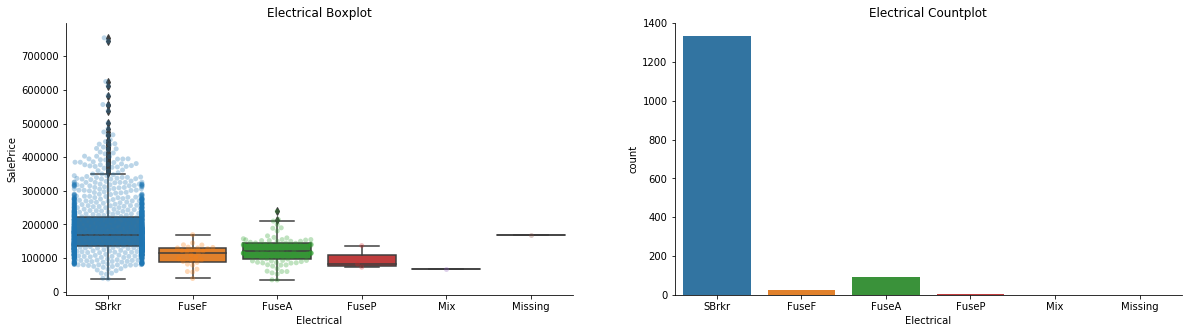

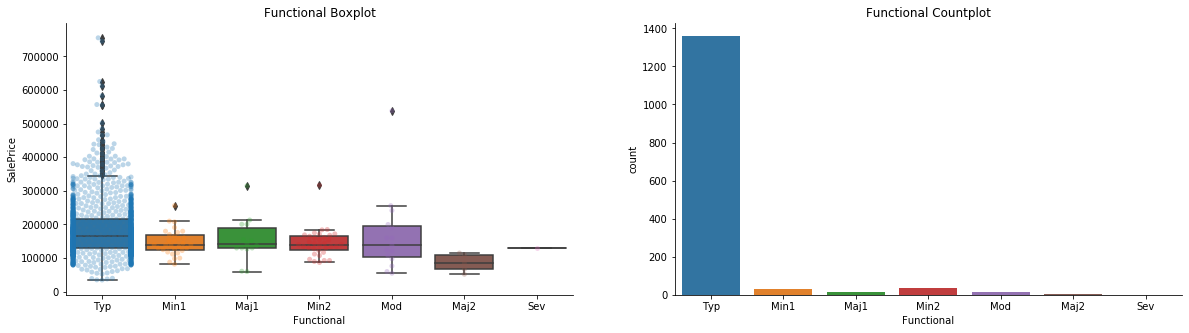

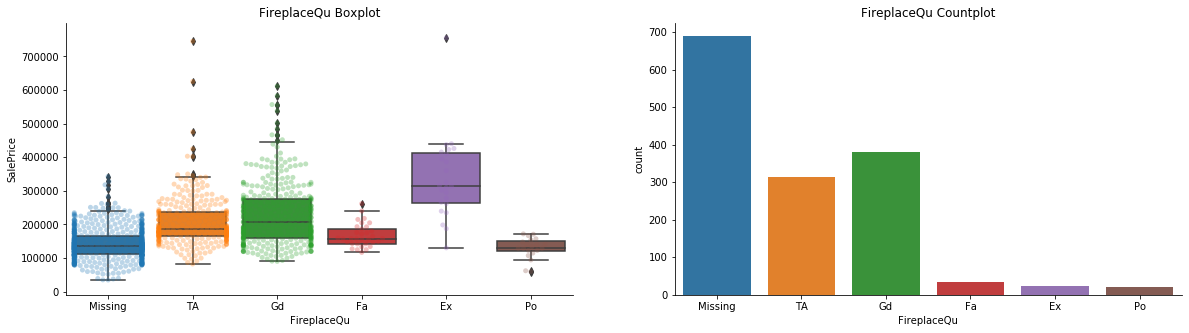

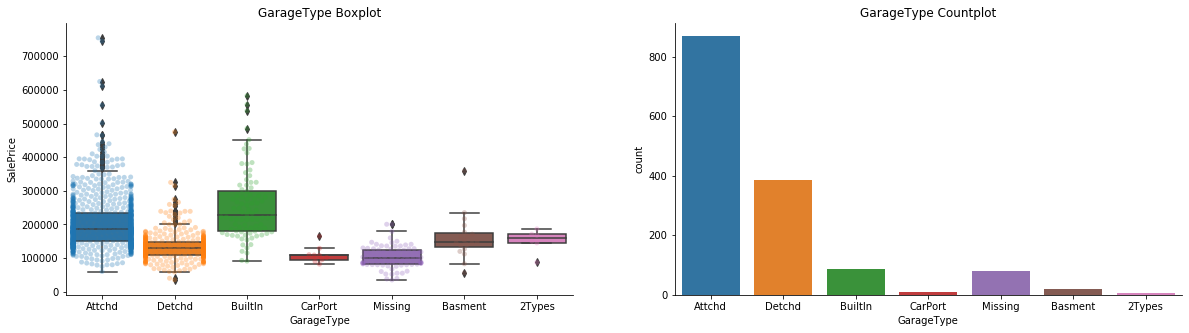

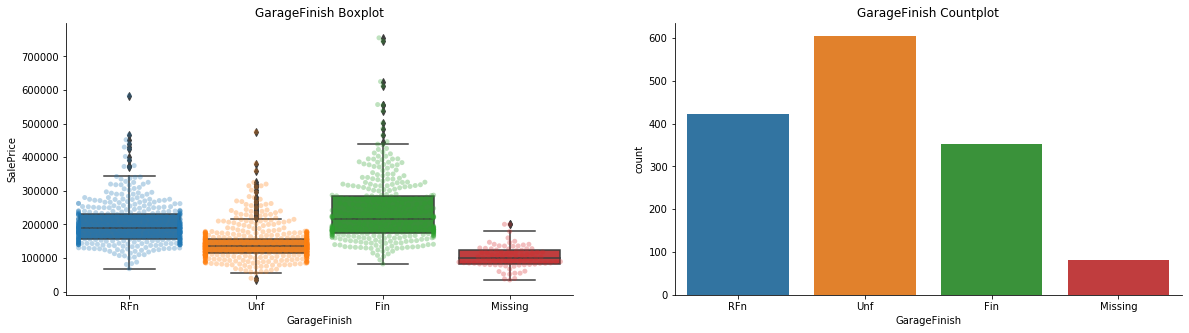

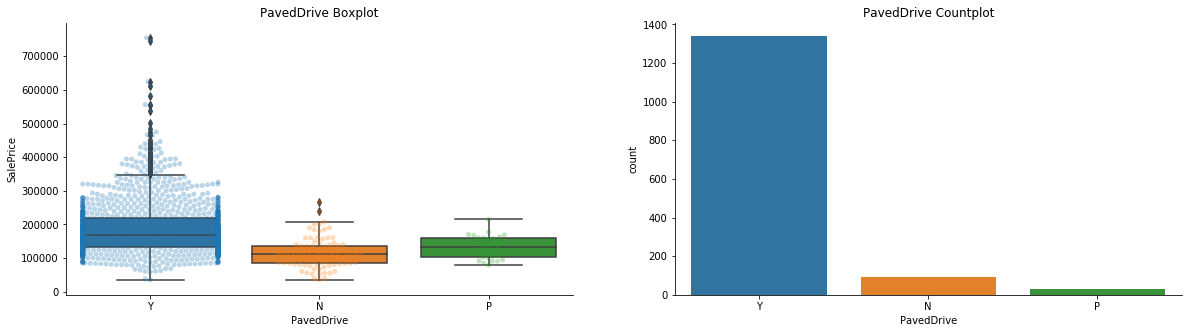

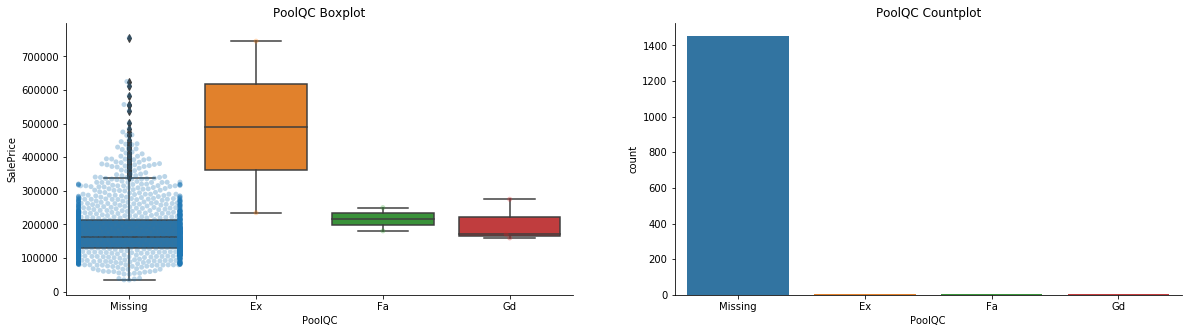

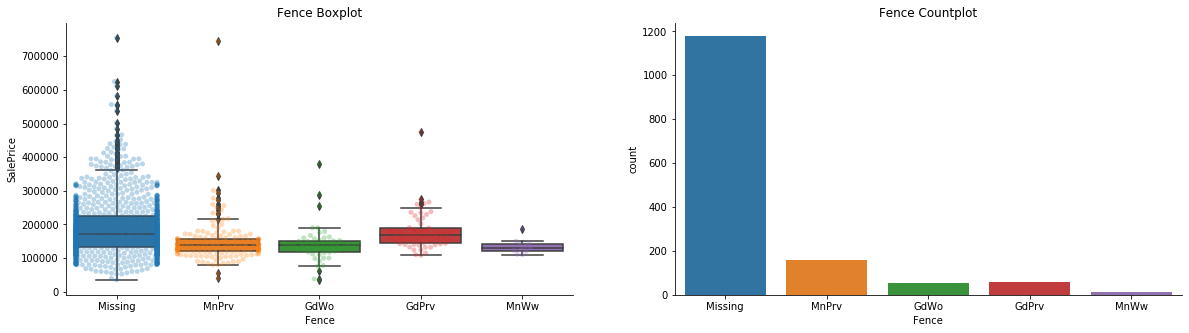

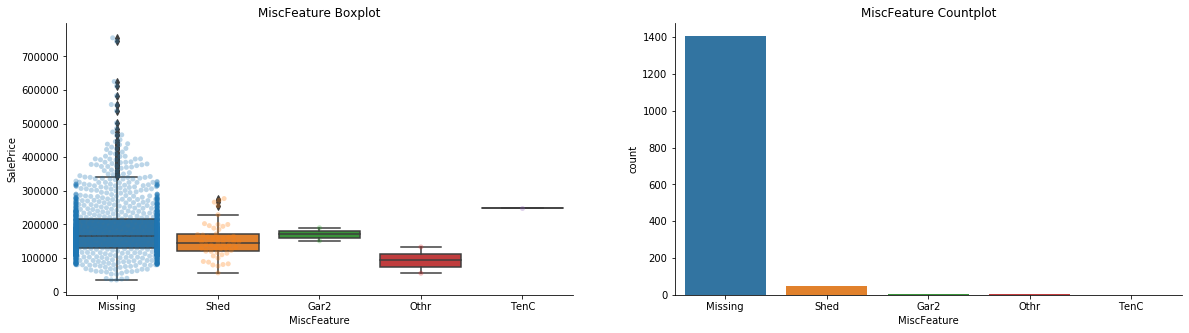

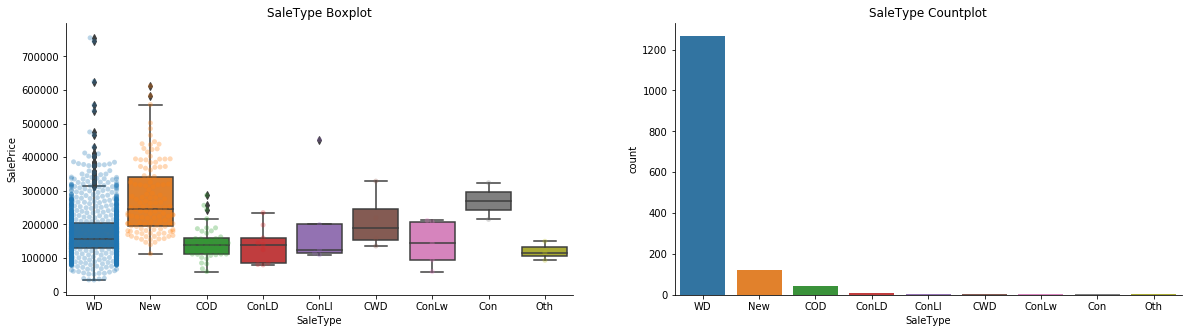

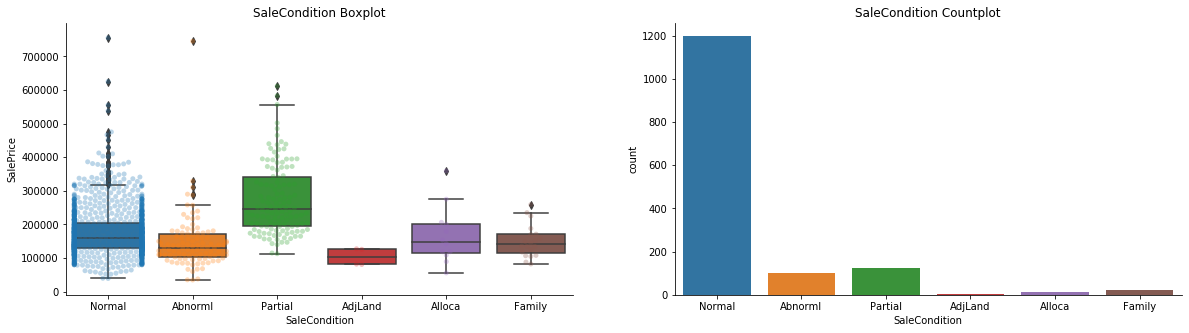

In [144]:
categorical_train = train[categorical].fillna("Missing")
for i in categorical_train.columns:
    if i == "SalePrice":
        continue
    fig, axes = plt.subplots(nrows =1, ncols = 2, figsize = (20,5))
    sns.boxplot(x = categorical_train[i], y = train["SalePrice"], ax = axes[0])
    sns.swarmplot(x = categorical_train[i], y = train["SalePrice"], ax = axes[0], alpha=0.3)
    sns.countplot(x = categorical_train[i], ax = axes[1])
    sns.despine()
    axes[0].set_title("{} Boxplot".format(i))
    axes[1].set_title("{} Countplot".format(i))
    plt.show()

## Outlier Scaling

Skewness: 2.163569
Kurtosis: 17.452867


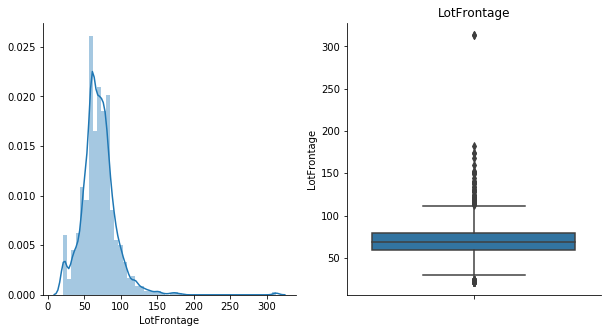

Skewness: 12.207688
Kurtosis: 203.243271


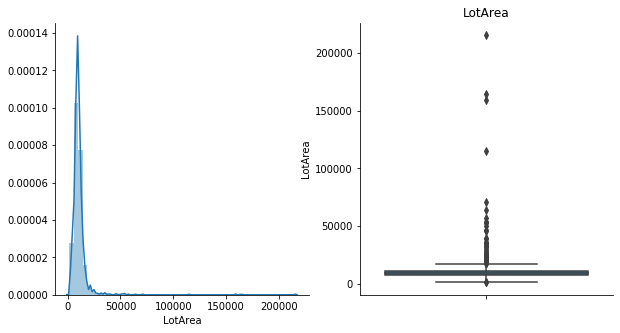

Skewness: 2.669084
Kurtosis: 10.082417


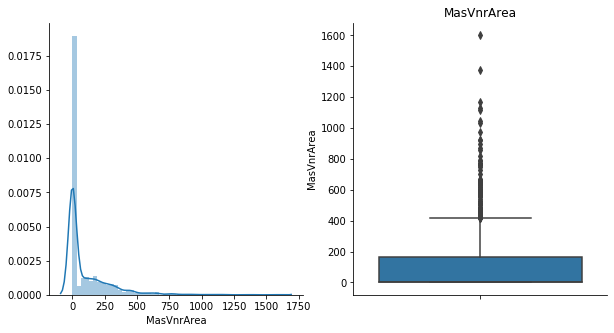

Skewness: 1.685503
Kurtosis: 11.118236


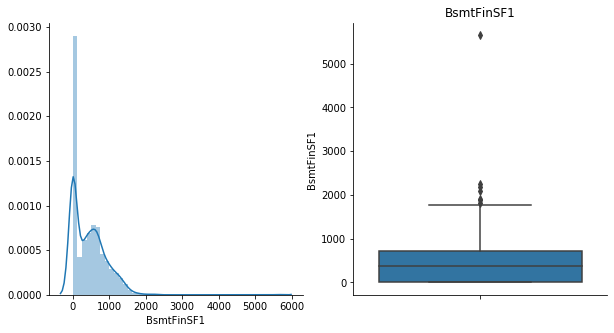

Skewness: 4.255261
Kurtosis: 20.113338


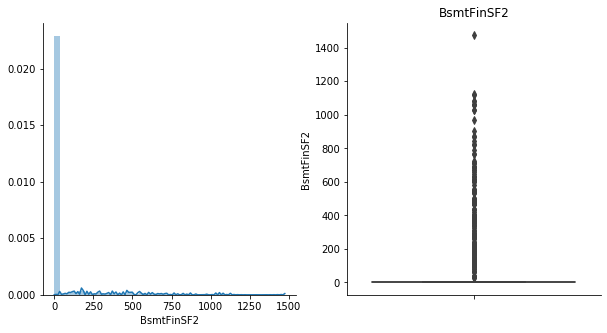

Skewness: 0.920268
Kurtosis: 0.474994


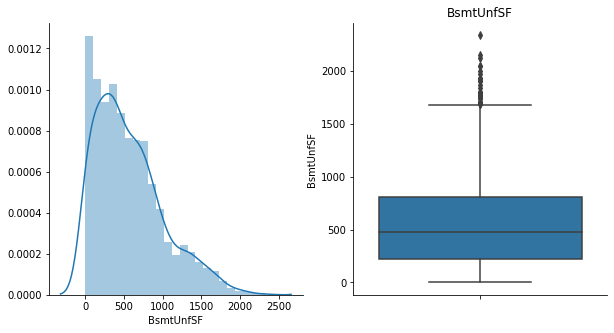

Skewness: 1.524255
Kurtosis: 13.250483


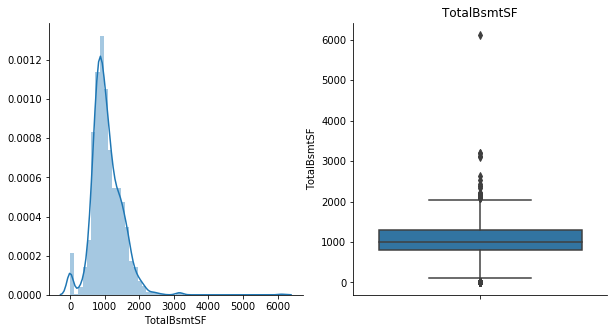

Skewness: 1.376757
Kurtosis: 5.745841


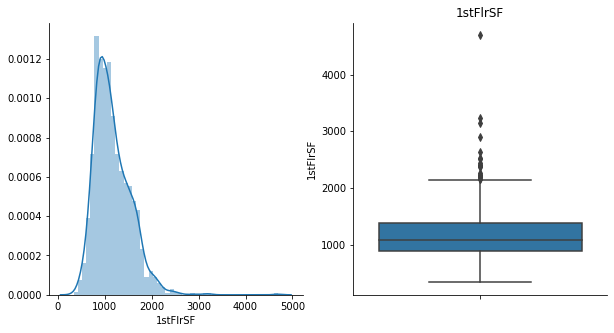

Skewness: 0.813030
Kurtosis: -0.553464


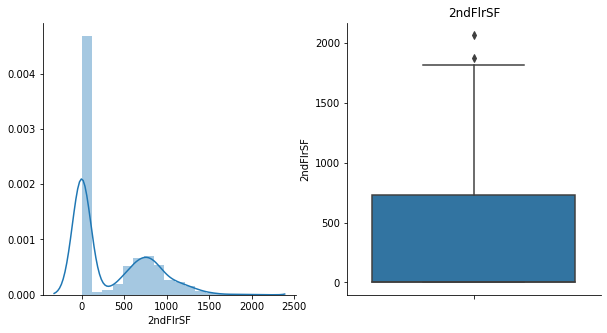

Skewness: 9.011341
Kurtosis: 83.234817


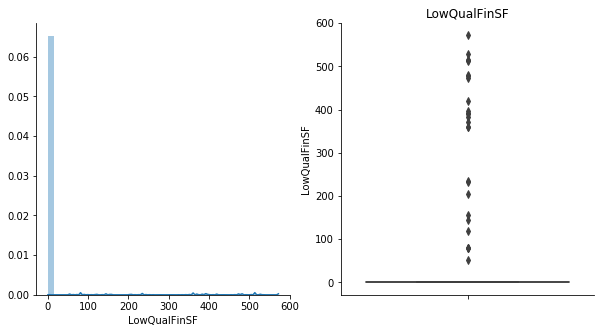

Skewness: 1.366560
Kurtosis: 4.895121


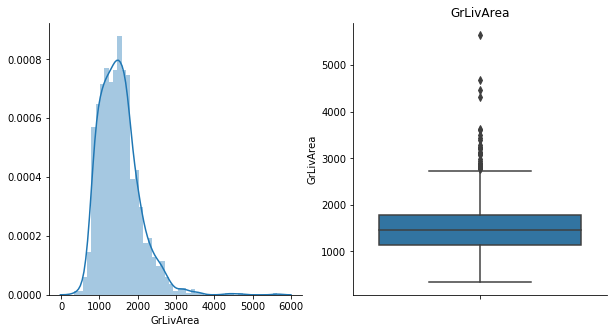

Skewness: 0.179981
Kurtosis: 0.917067


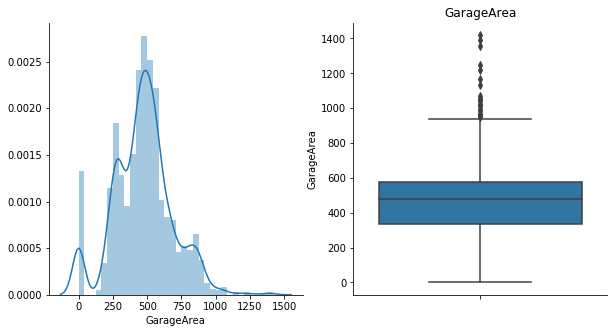

Skewness: 1.541376
Kurtosis: 2.992951


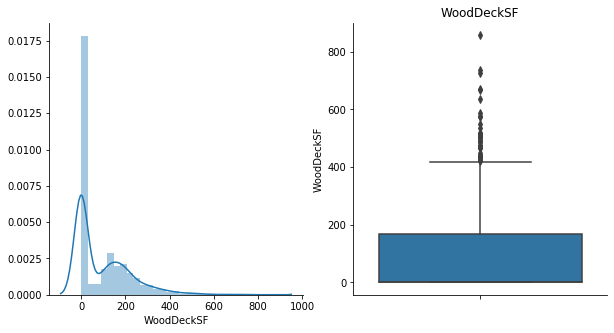

Skewness: 2.364342
Kurtosis: 8.490336


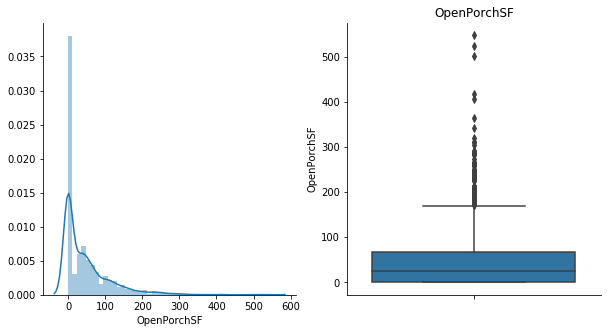

Skewness: 3.089872
Kurtosis: 10.430766


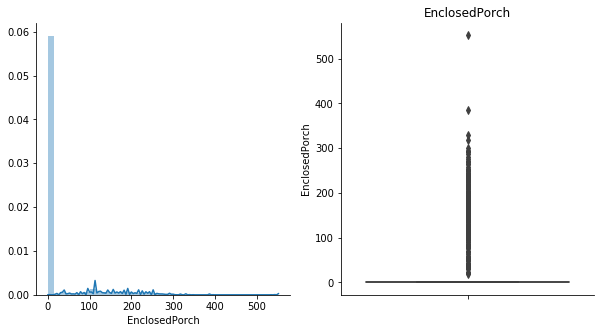

Skewness: 10.304342
Kurtosis: 123.662379


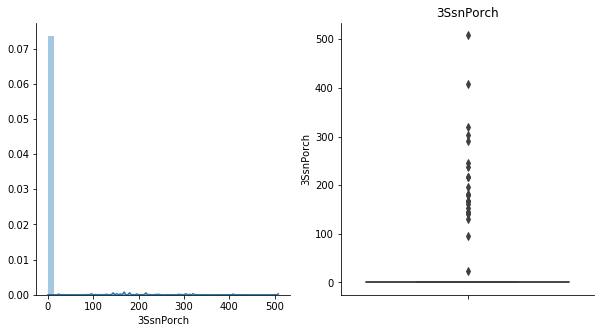

Skewness: 4.122214
Kurtosis: 18.439068


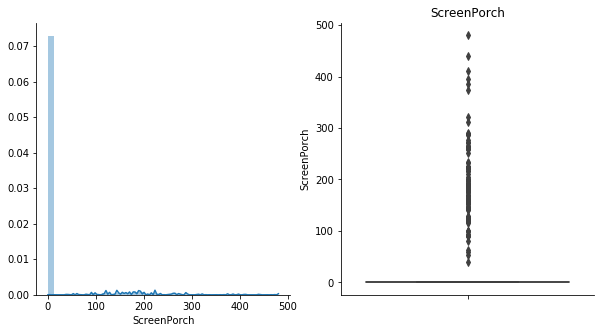

Skewness: 14.828374
Kurtosis: 223.268499


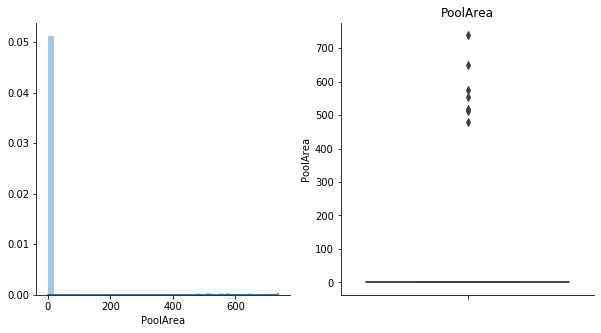

Skewness: 24.476794
Kurtosis: 701.003342


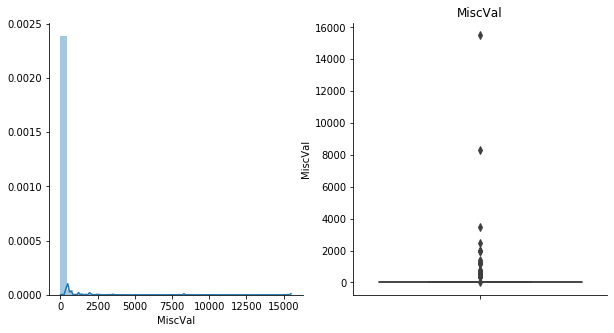

Skewness: 1.882876
Kurtosis: 6.536282


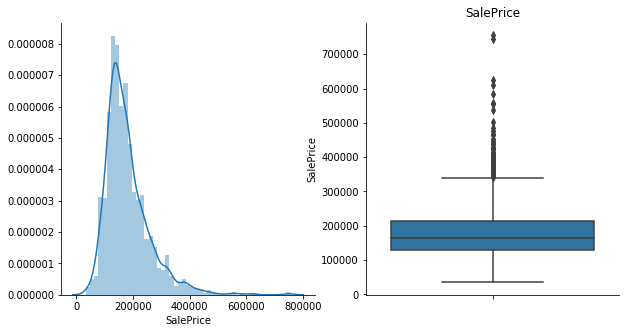

In [166]:
for i in train[numerical].columns:
    fig, axes = plt.subplots(nrows =1, ncols = 2, figsize = (10,5))
    
    sns.distplot(train[i].dropna(), ax = axes[0])
    sns.boxplot(train[i], ax = axes[1], orient = "v")
    
    print("Skewness: %f" % train[i].skew())
    print("Kurtosis: %f" % train[i].kurt())
    
    plt.title(i)
    sns.despine()
    plt.show()

## Analyzing Feature-Feature Relationship

### Pearson Correlation Cont Variables

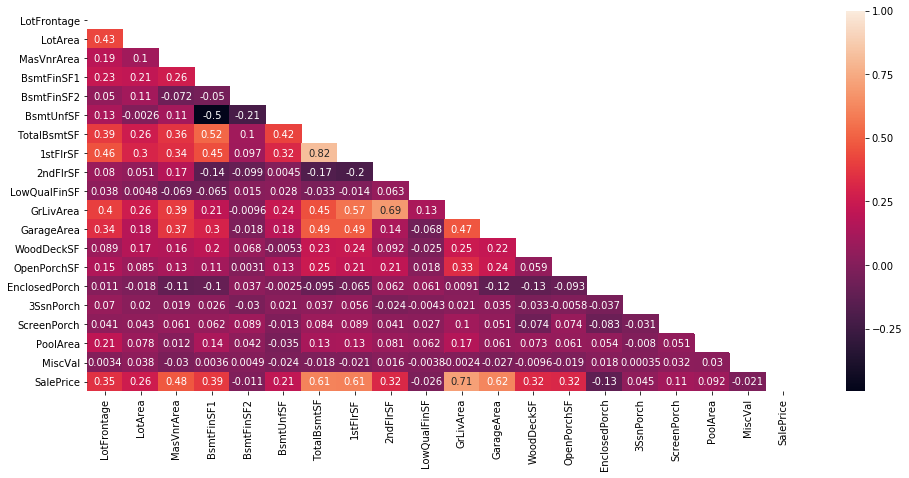

In [10]:
plt.figure(figsize = (16,7))
sns.heatmap(numerical_train.corr(), 
            mask = np.triu(np.ones_like(numerical_train.corr(), 
                                        dtype=np.bool)),
            annot = True)
plt.show()

- Nothing notable here, except that there are some high correlation between total basement square feet, and the first floor square feet. Which makes sense as your basement is dependent on how big your first floor is.

### Spearman Correlation Ranked Variable

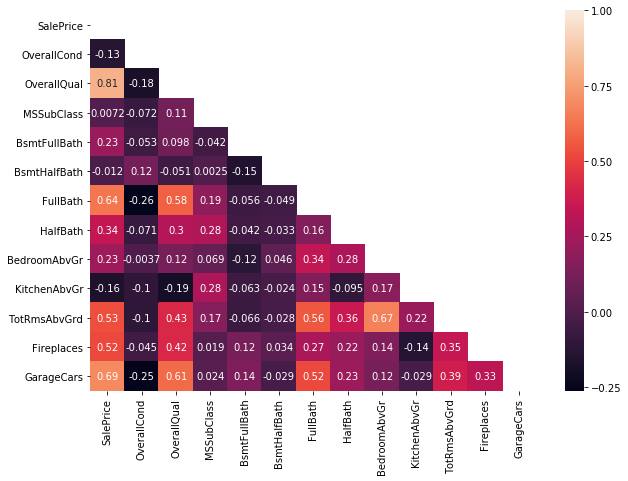

In [11]:
plt.figure(figsize = (10,7))
sns.heatmap(pd.concat([train[["SalePrice"]], levels_train], axis = 1).corr(method = "spearman"), 
            mask = np.triu(np.ones_like(pd.concat([train[["SalePrice"]], levels_train], axis = 1).corr(), 
                                        dtype=np.bool)),
            annot = True)
plt.show()

- Overall quality might somewhat be affected by size of garage
- Bedroom above grade proportional to total rms above grade, which makes sense as TotRmsAbvGrd is just a compouneded score

### Assessing Missingness (MNAR, MAR)

In terms of missingness of data, there are two types of missingness, first is that whether the missing is occuring at random, or when missingness can actually be an important covariate.

In [151]:
data = train.copy()

### Numerical 

In [152]:
data[numerical].isnull().mean()

LotFrontage      0.177397
LotArea          0.000000
MasVnrArea       0.005479
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtUnfSF        0.000000
TotalBsmtSF      0.000000
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
GarageArea       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
EnclosedPorch    0.000000
3SsnPorch        0.000000
ScreenPorch      0.000000
PoolArea         0.000000
MiscVal          0.000000
SalePrice        0.000000
dtype: float64

- Nothing notable, fill both with zero -> not having any instead of missing

In [153]:
data[levels].isnull().mean()

OverallCond     0.000000
OverallQual     0.000000
MSSubClass      0.000000
BsmtFullBath    0.000000
BsmtHalfBath    0.000000
FullBath        0.000000
HalfBath        0.000000
BedroomAbvGr    0.000000
KitchenAbvGr    0.000000
TotRmsAbvGrd    0.000000
Fireplaces      0.000000
GarageCars      0.000000
ExterQual       0.000000
ExterCond       0.000000
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.908219
HeatingQC       0.000000
KitchenQual     0.000000
GarageQual      0.055479
GarageCond      0.055479
dtype: float64

- missing to zero, indicating unavailability

In [154]:
data[temporal].isnull().mean()

YearBuilt       0.000000
YearRemodAdd    0.000000
GarageYrBlt     0.055479
MoSold          0.000000
YrSold          0.000000
dtype: float64

- Remove -> change to whether having a garage or not

In [155]:
data[categorical].isnull().mean()

MSZoning         0.000000
Street           0.000000
Alley            0.937671
LotShape         0.000000
LandContour      0.000000
Utilities        0.000000
LotConfig        0.000000
LandSlope        0.000000
Neighborhood     0.000000
Condition1       0.000000
Condition2       0.000000
BldgType         0.000000
HouseStyle       0.000000
RoofStyle        0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
MasVnrType       0.005479
Foundation       0.000000
BsmtFinType1     0.025342
BsmtFinType2     0.026027
Heating          0.000000
CentralAir       0.000000
Electrical       0.000685
Functional       0.000000
FireplaceQu      0.472603
GarageType       0.055479
GarageFinish     0.055479
PavedDrive       0.000000
PoolQC           0.995205
Fence            0.807534
MiscFeature      0.963014
SaleType         0.000000
SaleCondition    0.000000
dtype: float64

- MasVnrType combine none with missing
- Basement to missing 
- Fireplace Quality impute with missing
- Pool impute with missing (rare label -> change to binary)
- MiscFeature impute with missing (rare labels -> change to binary)
- Alley (rare labels -> change to binary)
- Electrical (change to mode or median) will not change distribution

In the categorical variables, we can see that there is indeed more number of missingness, however, these missingness are something that is important towards pricing a house in real life, having a pool or alley, might be an indication of wealth. And the rest of the features that is missing is not an occurence of being missing at random, but is a signal in itself as it is missing because they dont have a garage, basement, or MasVnrType (which is notable on those category that is empty, the house sale did not report the calculation in the numerical variables.

### Predictive Power Scoring on each Variables Using Decision Tree

In handling regression problem, it is to our best interest that we are not handling variables that is correlated to each other, otherwise it might cause redundancy and unstable "linear" regression model. This is not the case with trees model, however it is always a better practice to see whether if we can combine features into one.

In [28]:
pps_score = assess_pps(train)

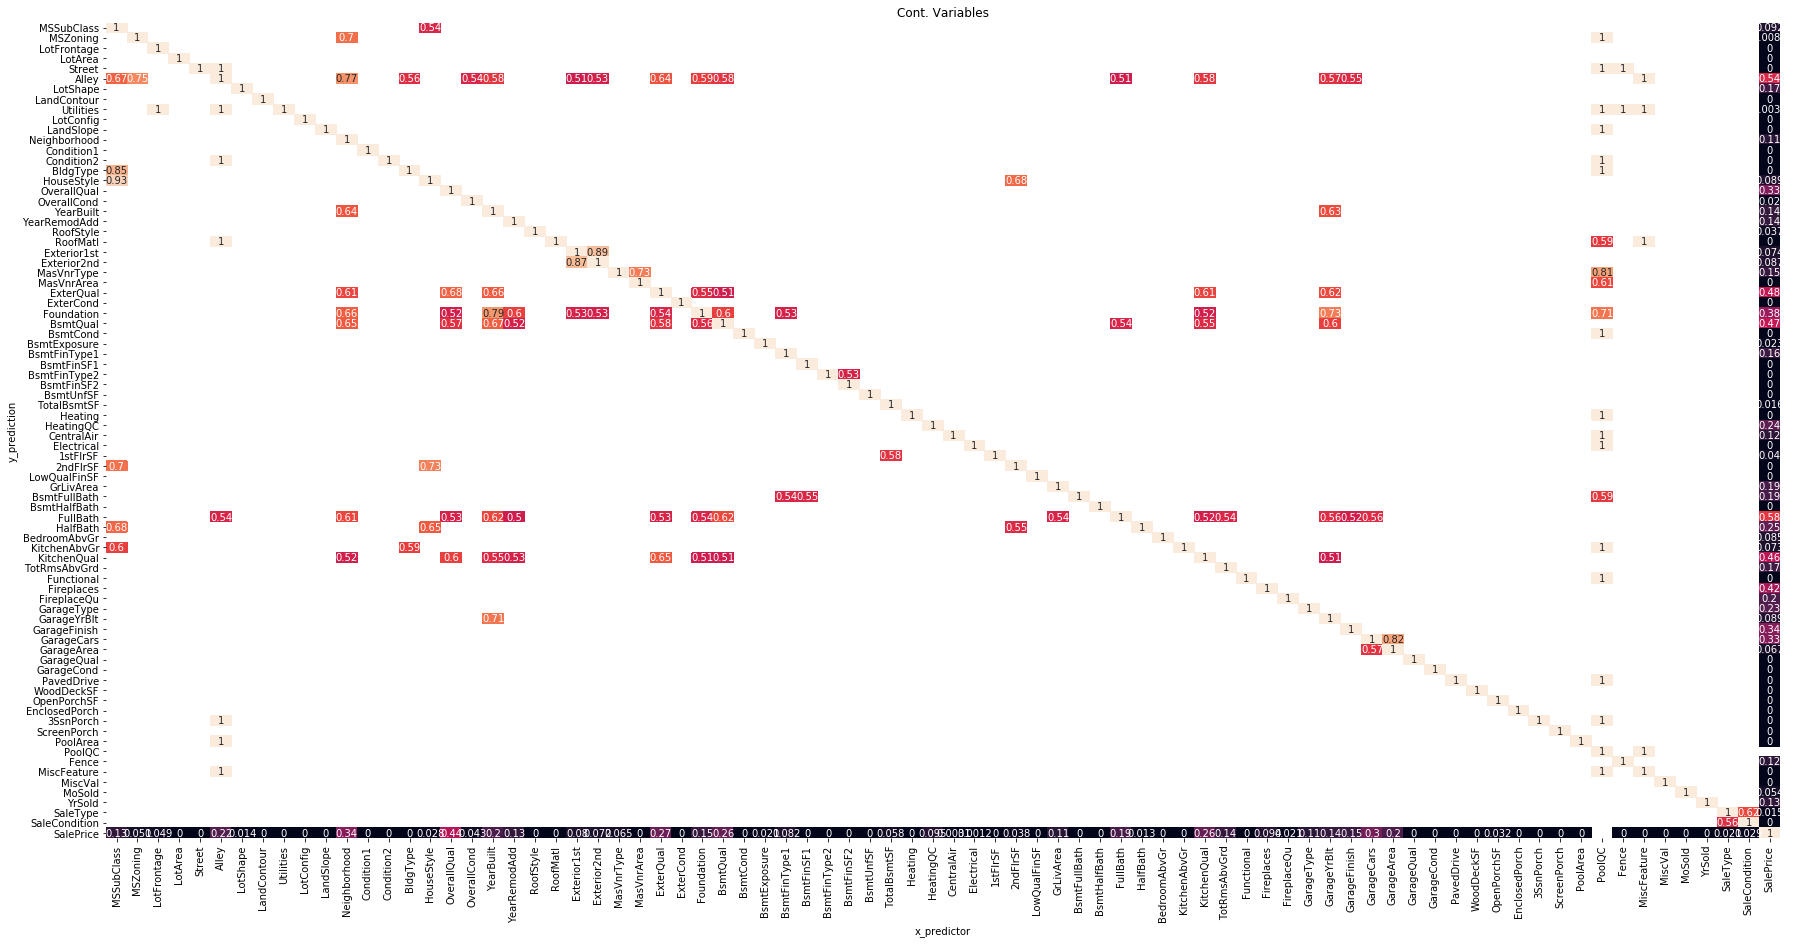

In [24]:
plt.figure(figsize = (30,15))
sns.heatmap(pps_score, 
            annot = True, 
            cbar = False)
plt.xlabel("x_predictor")
plt.ylabel("y_prediction")
plt.title("Cont. Variables")
plt.show()

- Some Interesting takeaways, MSSubClass (Identifies the type of dwelling involved in the sale) is a good predictor towards building type, and the house style
- Rare labels like Alleys and Pools are able to perfectly predict some of the house features especially in way that it is a causalty effect of having a higher income housing
- Exterior design 1 are able to predict exterior design 2 as people might have the tendency to get a well known combination of exterior polish

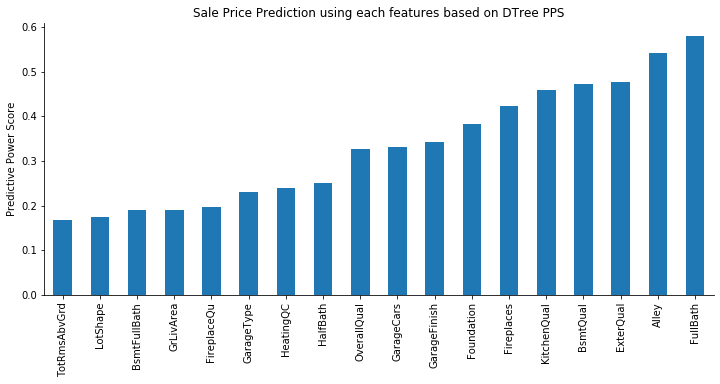

In [128]:
plt.figure(figsize = (12,5))
(pps_score["SalePrice"].sort_values(ascending = True).tail(20))[:-2].dropna().plot(kind = "bar")
sns.despine()
plt.title("Sale Price Prediction using each features based on DTree PPS")
plt.ylabel("Predictive Power Score")
plt.show()

In terms of SalePrice by each PPS decision tree, this is still a naive representation of how each features independently affect the SalePrice.